# Census Income Prediction

In [33]:
import urllib.request
import shutil

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from pathlib import Path

### Load Data

In [2]:
PROJECT_PATH = Path('/home/ubuntu/flatworld/')
DATA_DIR = PROJECT_PATH / 'data'

In [3]:
with (DATA_DIR / 'census_income_metadata.txt').open('r') as fin:
    metadata_desc = fin.read()
metadata = metadata_desc.split('|')
metadata = [md.strip() for md in metadata][1:]

In [4]:
col_info = [xx for xx in metadata if 'attribute #' in xx]

col_distinct = [int(col.split(' ')[0]) for col in col_info]
col_nums = [int(xx.split('#')[1][:2]) for xx in col_info]
col_types = [col[(col.find(')') + 2):] for col in col_info]
col_names = [col[col.find('(')+1:col.find(')')] for col in col_info]
# NOTE: Having chosen to pull column names from these lines was a bit unfortunate because
#  the 24th entry in the csv is actually the instance weight as shown in lines 24-68 of
#  the metadata text file. This is skipped over in these lines, so attribute # doesn't
#  actually correspond to column location in the csv. Seems like this should be
#  pointed out more explicitly somewhere in the file.

col_info_df = pd.DataFrame([xx for xx in zip(col_names, col_types, col_distinct)], columns=['col_names', 'col_type', 'col_distinct'], index=col_nums)
col_info_df.head()

,col_names,col_type,col_distinct
0,age,continuous,91
1,class of worker,nominal,9
2,detailed industry recode,nominal,52
3,detailed occupation recode,nominal,47
4,education,nominal,17


In [5]:
idxs = [xx for xx in range(42)]
idxs.pop(24)
idxs
col_names.append('target')
col_name_map = dict(zip(idxs, col_names))

In [6]:
census_df = pd.read_csv(DATA_DIR / 'census_income_learn.csv',header=None)
instance_weights = census_df.pop(24)
census_df.rename(columns=col_name_map, inplace=True)
census_df['target'] = census_df['target'].apply(lambda x: int(x == ' 50000+.'))
census_df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


In [7]:
census_df['target'].value_counts()

0    187141
1     12382
Name: target, dtype: int64

## Explore Data

Below I do some basic data exploration to look for any data quality issues and to get an intuitive feel for the dataset.

###  Inspect Metadata statistics

In [8]:
col_info_df.sort_values('col_distinct', ascending=False)

,col_names,col_type,col_distinct
18,dividends from stocks,continuous,1478
5,wage per hour,continuous,1240
16,capital gains,continuous,132
17,capital losses,continuous,113
0,age,continuous,91
38,weeks worked in year,continuous,53
2,detailed industry recode,nominal,52
21,state of previous residence,nominal,51
3,detailed occupation recode,nominal,47
31,country of birth father,nominal,43


##### Thoughts:

1. The main issue that pops out to me here is the difficulty in **dealing with nominal (categorical) data that has a large number of categories**.
    * This is because when working with categorical data we typically preprocess the data by converting the single column with $N$ distinct values into $N$ columns which are binary encoded. e.g. if we have a column $\texttt{gender}$ with values $[\texttt{gender}] \in [\{\texttt{male, female, other}\}]$, then we map this column to three columns $[\texttt{gender}] \rightarrow [\texttt{gender_male, gender_female, gender_other}] \in [\{0, 1\}, \{0, 1\}, \{0, 1\}]$. However, for features with a large number of possible values this can cause the dimension of our feature space to increase dramatically, extending it beyond the capacity of our dataset.
    * A first approach to handle this type of issue is to simply try to ignore this dimension and see if the model performs adequately without it. This is what I will do now, but I imagine that this will be sub-optimal as some of these high-dimensional features contain superfically relevant information, e.g. indusrty and occupation codes. ***More on this below.***

In [9]:
# If we naively applied this methodology the dimension of our feature space would increase from 40 to
# such a large number it causes an integer overflow to calculate it
n_nom_cols_cart_prod = col_info_df[col_info_df['col_type'] == 'nominal']['col_distinct'].product()
n_cont_cols = col_info_df[col_info_df['col_type'] == 'continuous'].shape[0]
print('Dimensionality of naive feature space would be {}'.format(n_nom_cols_cart_prod * n_cont_cols))

Dimensionality of naive feature space would be 6353374019336536064


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in long_scalars


In [10]:
# # Download supplementary files from web
# urls = [
#     'https://www.census.gov/eos/www/naics/2002NAICS/2002_Definition_File.pdf',
#     'https://www.census.gov/eos/www/naics/reference_files_tools/2002/naics_2_6_02.txt'
# ]
# file_names = [
#     '2002_Definition_File.pdf',
#     'naics_2_6_02.txt'
# ]
# for url, file_name in zip(urls, file_names):
#     with urllib.request.urlopen(url) as response, open(DATA_DIR / file_name, 'wb') as out_file:
#         shutil.copyfileobj(response, out_file)

2. Though the data was categorized into $[\texttt{Data}] = [\texttt{continuous}] \otimes [\texttt{nominal}]$, this decomposition is perhaps a bit too coarse. **Nominal data assumes that there is no natural metric relationship between the categories, but this is not necessarily true, e.g. geographical data**, populations in nearby locations are more likely to be similar than between more distant locations.
    * ***Should be safe to ignore this additional information***, but should be kept in mind when it comes time to optimize the model.

### Inspect data for any obvious quality issues

In [11]:
# Check for nulls
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
age                                           199523 non-null int64
class of worker                               199523 non-null object
detailed industry recode                      199523 non-null int64
detailed occupation recode                    199523 non-null int64
education                                     199523 non-null object
wage per hour                                 199523 non-null int64
enroll in edu inst last wk                    199523 non-null object
marital stat                                  199523 non-null object
major industry code                           199523 non-null object
major occupation code                         199523 non-null object
race                                          199523 non-null object
hispanic origin                               199523 non-null object
sex                                           199523 non-null obj

In [12]:
cont_cols = col_info_df[col_info_df['col_type'] == 'continuous']['col_names'].values
nom_cols = col_info_df[col_info_df['col_type'] == 'nominal']['col_names'].values

#### Inspect continuous data

In [13]:
# Check continuously valued columns
census_df[sorted(cont_cols)].describe()

,age,capital gains,capital losses,dividends from stocks,num persons worked for employer,wage per hour,weeks worked in year
count,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,434.71899,37.313788,197.529533,1.956180,55.426908,23.174897
std,22.310895,4697.53128,271.896428,1984.163658,2.365126,274.896454,24.411488
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.00000,0.000000,0.000000,1.000000,0.000000,8.000000
75%,50.000000,0.00000,0.000000,0.000000,4.000000,0.000000,52.000000
max,90.000000,99999.00000,4608.000000,99999.000000,6.000000,9999.000000,52.000000


In [14]:
def compare_hist(field, thresh=0, bins=25, sharex=True, sharey=True):
    """Plots three histograms representing the total population, the ones making over 50000,
       and those making below 50000.
       
       args:
         field - which continuous feature to plot
         thresh - arbitrary threshold to set on field to clean up visualization
         bins - number of bins
         sharex - equalize x-axes in plots
         sharey - equalize y-axes in plots
    """
    colors = {
        'tot': '#5D3A72',
        'pos': '#A85153',
        'neg': '#4B5872'
    }
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=sharex, sharey=sharey)
    ax[0].hist(census_df[census_df[field] > thresh][field].values , bins=bins, color=colors['tot'], label='Total')
    ax[1].hist(census_df[(census_df[field] > thresh) & (census_df['target'] == 1)][field].values, bins=bins, color=colors['pos'], label='>50000')
    ax[2].hist(census_df[(census_df[field] > thresh) & (census_df['target'] == 0)][field].values, bins=bins, color=colors['neg'], label='<50000')
    [a.legend(loc='upper right') for a in ax]
    ax[0].set_ylabel(field)
    fig.show()

##### age

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


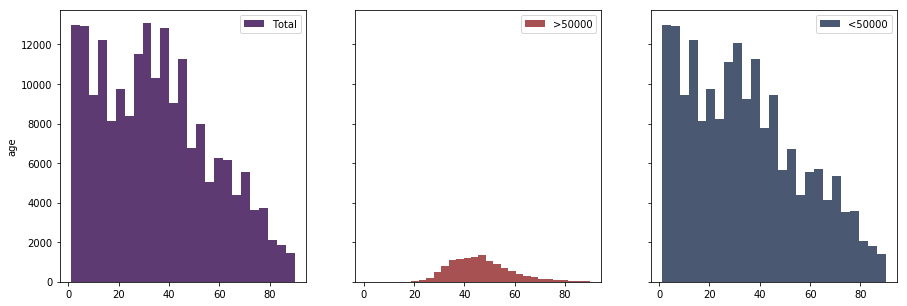

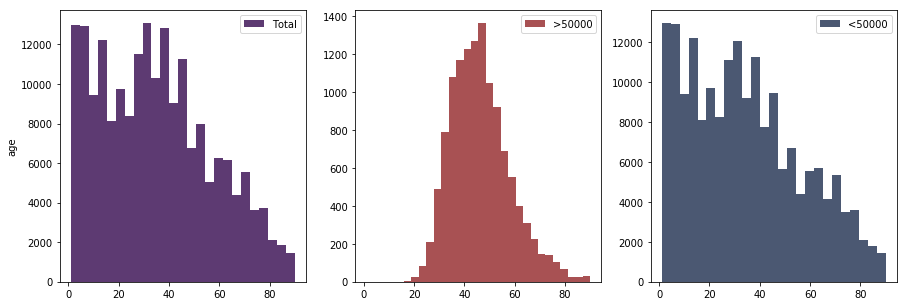

In [60]:
compare_hist('age')
compare_hist('age', sharey=False)

* No obvious signs of quality issues
* Negative population statistics seems to mirror total population
* Positive population seems normally distributed about ~50

##### capital gains

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


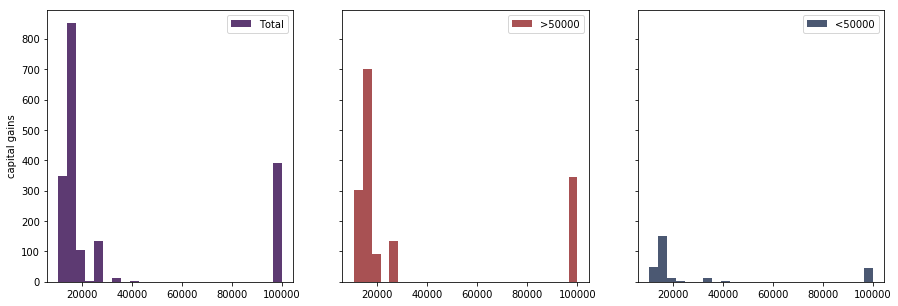

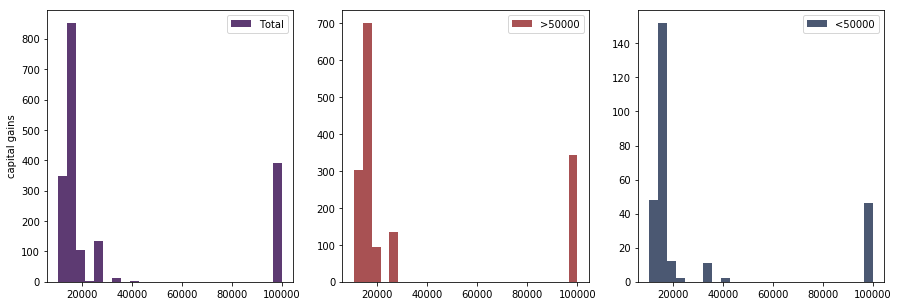

In [16]:
compare_hist('capital gains', 10000.0)
compare_hist('capital gains', 10000.0, sharey=False)

* No obvious quality issues
* Both positive and negative group statistics seem similar to total statistics
* Slight preponderance of very large capital gains in positive group, which makes sense

##### capital losses

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


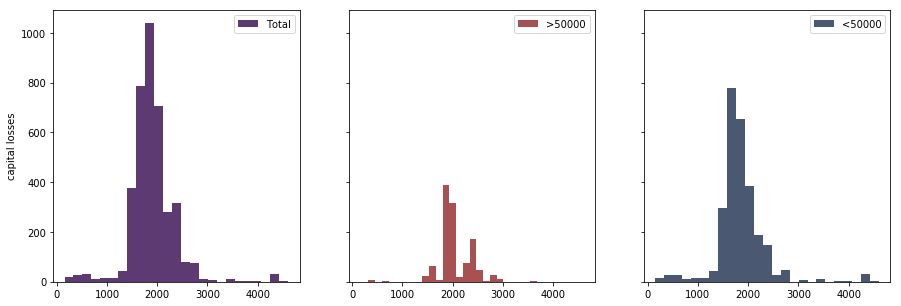

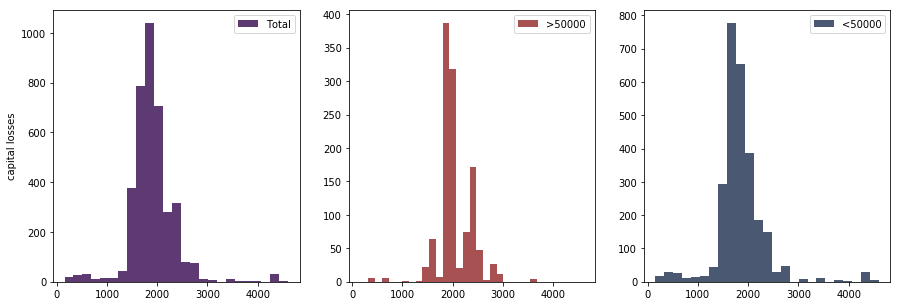

In [17]:
compare_hist('capital losses', 100.0)
compare_hist('capital losses', 100.0, sharey=False)

* No obvious quality issues
* Positive and negative statistics seem similar to total statistics
* Interestingly, there seems to be a very slight over-representation of large capital losses in the negative group than in the over. This seems plausible, but the signal is so slight, I doubt it would stand up to rigorous statistical tests.

##### dividends from stocks

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


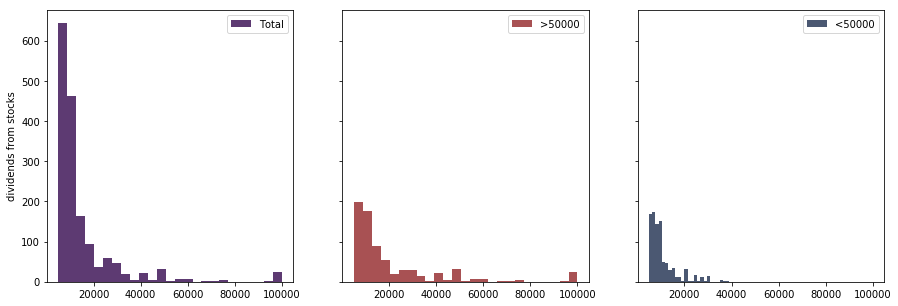

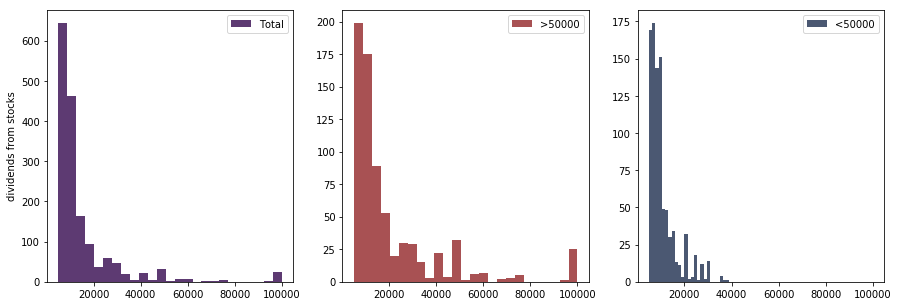

In [18]:
compare_hist('dividends from stocks', 5000.0)
compare_hist('dividends from stocks', 5000.0, sharey=False)

* No obvious quality issues
* Positive and negative statistics seem mostly similar to total statistics
* (Nearly) all of those that had very large stock dividends were in the positive group, which makes sense

##### num persons worked for employer

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


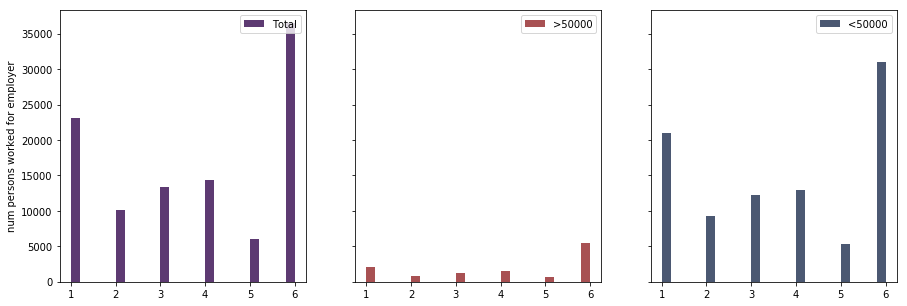

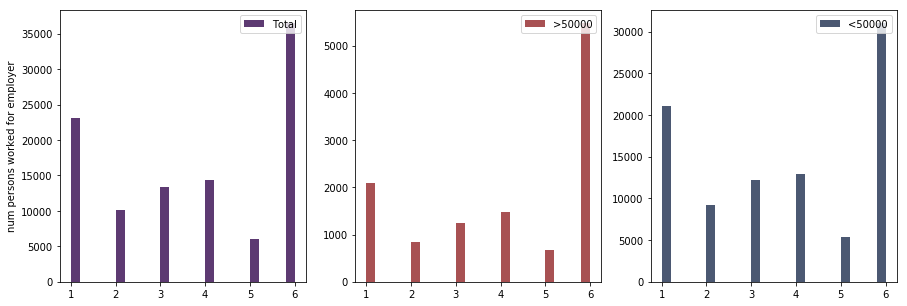

In [19]:
compare_hist('num persons worked for employer')
compare_hist('num persons worked for employer', sharey=False)

* No obvious quality issues
* Positive and negative statistics seem mostly similar to total statistics
* It seems that those in the positive group were more likely to work for a large company (category 6: >1000 employees) than a small company (category 1: <10 employees). Which seems reasonable.

##### wage per hour

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


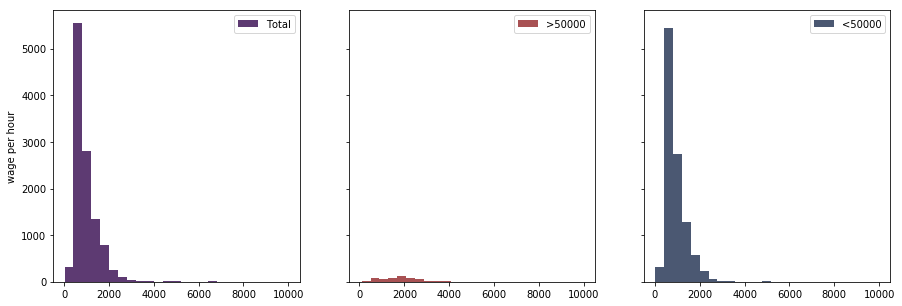

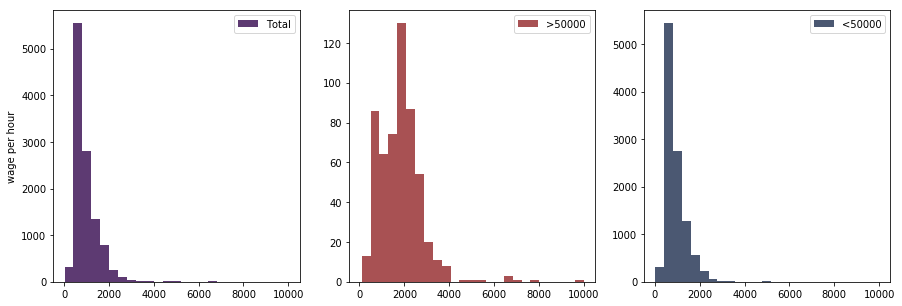

In [20]:
compare_hist('wage per hour')
compare_hist('wage per hour', sharey=False)

* No obvious quality issues
* Positive statistics seem very slightly more normally distributed, whereas negative group much more heavy tailed
* **Seems like a Maxwell-Boltzman distribution, which, in analogy to physics, describes the distributions of speed in a gas. In this analogy it would seem that the group making above 50000 have a higher "temperature" or a lower "mass", which could be interpreted as those employees work in industries which have more money to spend on wages (higher temp - more energy to spread around), or have backgrounds/skills that make them easier to promote from low paying jobs to high paying jobs (low mass - easy to accelerate).**

##### weeks worked in year

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


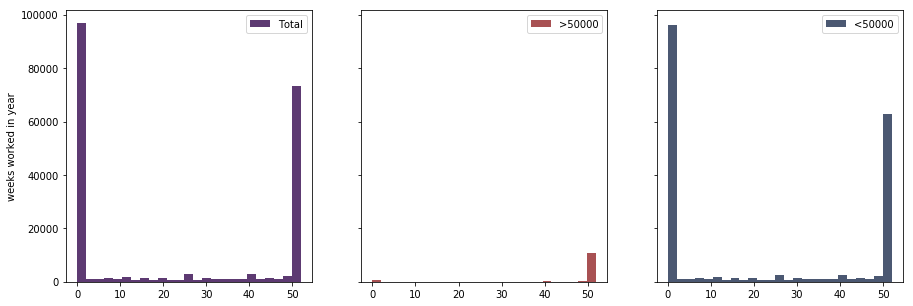

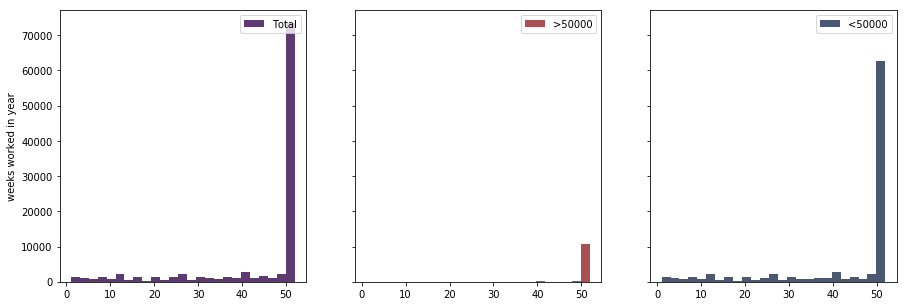

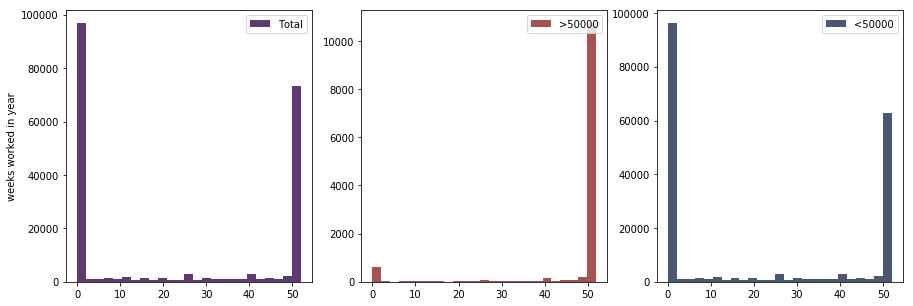

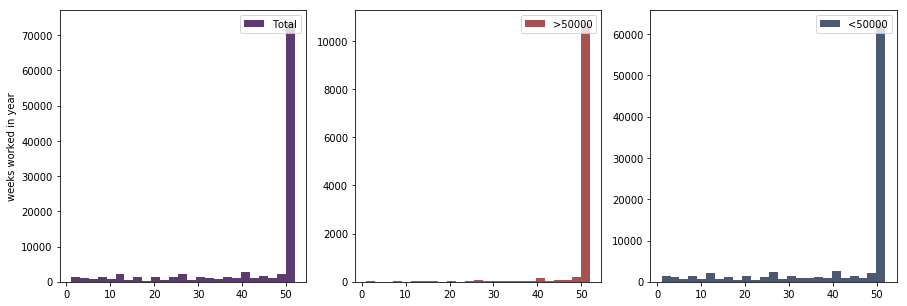

In [21]:
compare_hist('weeks worked in year', -0.01)
compare_hist('weeks worked in year', 0.0)                    # Ignore contribution from those unemployed all year
compare_hist('weeks worked in year', -0.01, sharey=False)
compare_hist('weeks worked in year', 0.0, sharey=False)      # Ignore contribution from those unemployed all year

* No obvious quality issues
* Not surprisingly, those making above 50000 are almost entirely employed all year, but interestingly there are a few hundred making above 50000 and not employed all year. (Must be nice :/ ...)
* Those making below 50000 make up almost the entire population of unemployed and also have almost all of the variation in employment levels.

#### Inspect Nominal Data

In [180]:
nom_cols_less = col_info_df[(col_info_df['col_type'] == 'nominal') & (col_info_df['col_distinct'] < 30)]['col_names'].values
nom_cols_less

array(['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code',
       'race', 'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'citizenship', 'own business or self employed',
       "fill inc questionnaire for veteran's admin", 'veterans benefits',
       'year'], dtype=object)

In [222]:
def compare_bar_nom(field,sharex=True, sharey=True):
    """Plots three bar charts representing the total population, the ones making over 50000,
       and those making below 50000.
       
       args:
         field - which continuous feature to plot
         sharex - equalize x-axes in plots
         sharey - equalize y-axes in plots
    """
    colors = {
        'tot': '#5D3A72',
        'pos': '#A85153',
        'neg': '#4B5872'
    }
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=sharex, sharey=sharey)
    tot = census_df[field].value_counts(dropna=False).sort_index().fillna(0)
    neg = census_df[census_df['target'] == 0][field].value_counts(dropna=False).sort_index().fillna(0)
    pos = census_df[census_df['target'] == 1][field].value_counts(dropna=False).sort_index().fillna(0)
    full = pd.DataFrame({'tot': tot, 'pos': pos, 'neg':neg})
    idx = np.arange(0, tot.shape[0])
    ax[0].bar(idx, list(full['tot'].values), tick_label=list(full['tot'].keys()), color=colors['tot'], label='Total')
    ax[1].bar(idx, list(full['pos'].values), tick_label=list(full['pos'].keys()), color=colors['pos'], label='>50000')
    ax[2].bar(idx, list(full['neg'].values), tick_label=list(full['neg'].keys()), color=colors['neg'], label='<50000')
    for a in ax:
        a.legend(loc='upper right')
        for tick in a.get_xticklabels():
            tick.set_rotation(90)
    ax[0].set_ylabel(field)
    plt.show()
    plt.close()

################################################################################
################################# citizenship ##################################
################################################################################


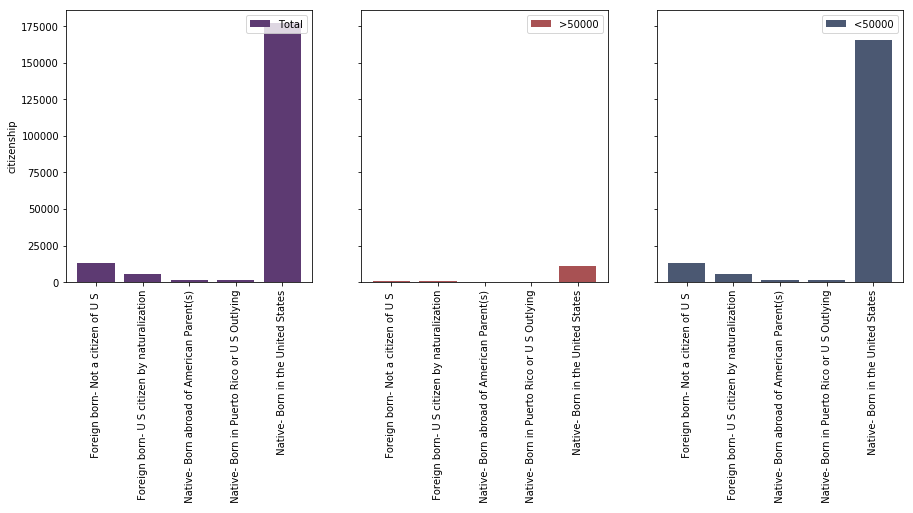

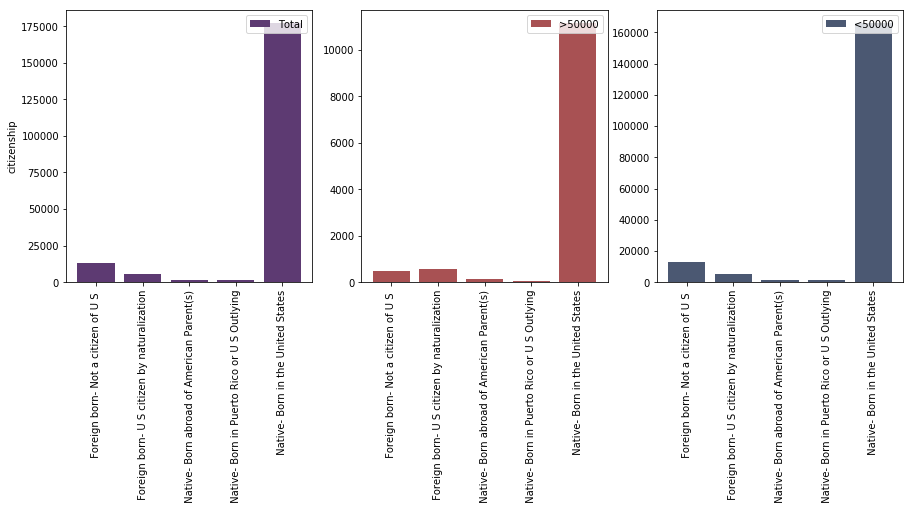

################################################################################
############################### class of worker ################################
################################################################################


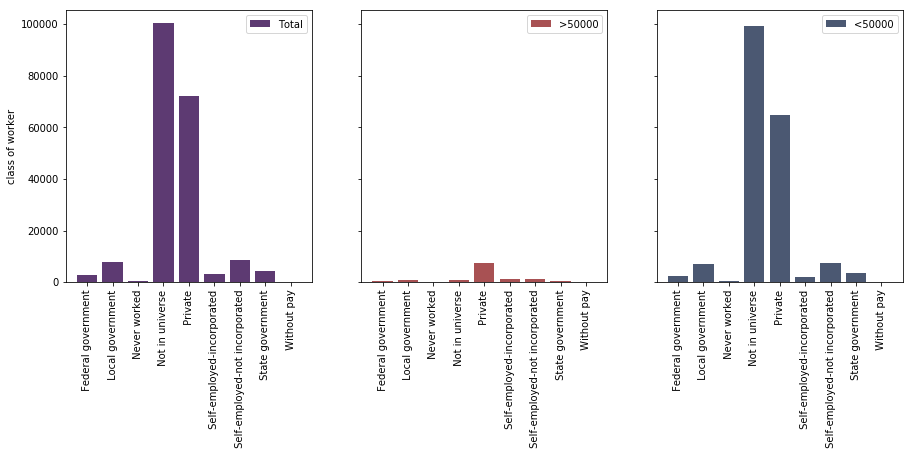

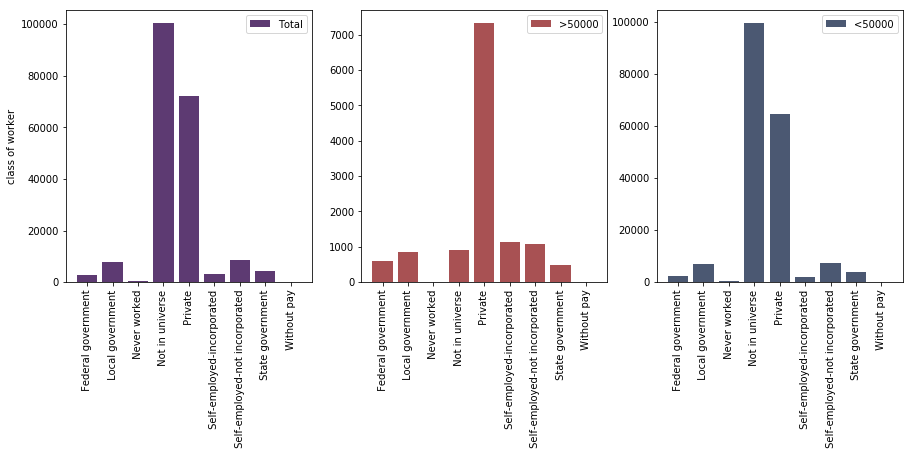

################################################################################
########################### country of birth father ############################
################################################################################


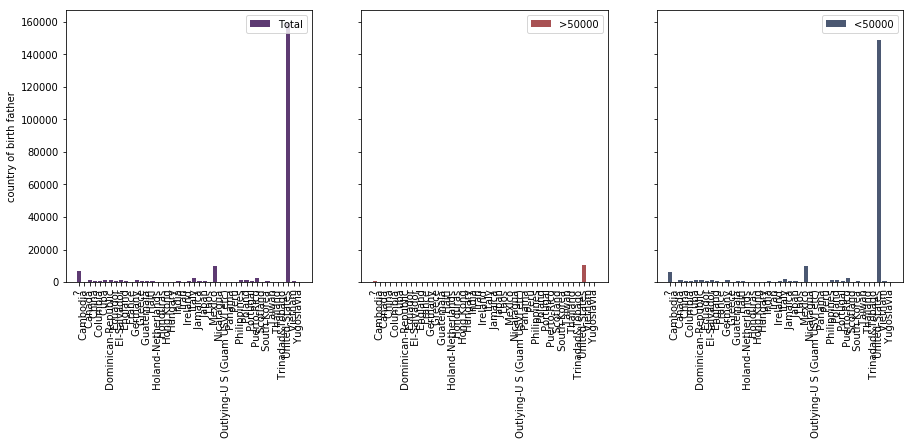

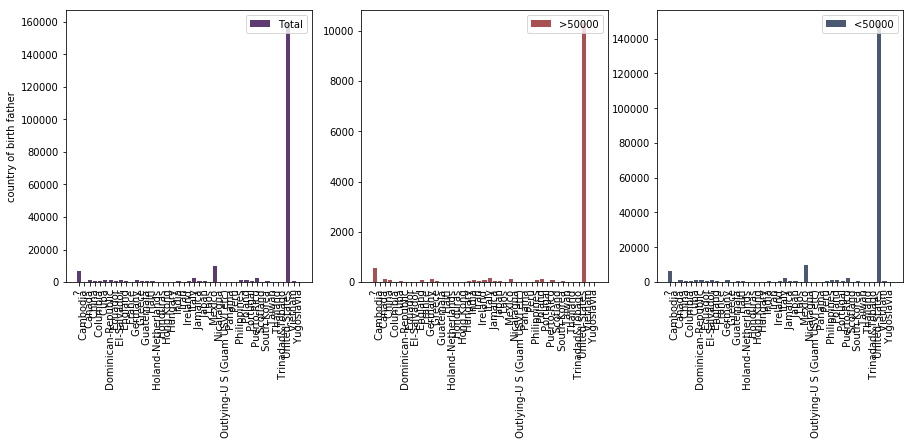

################################################################################
########################### country of birth mother ############################
################################################################################


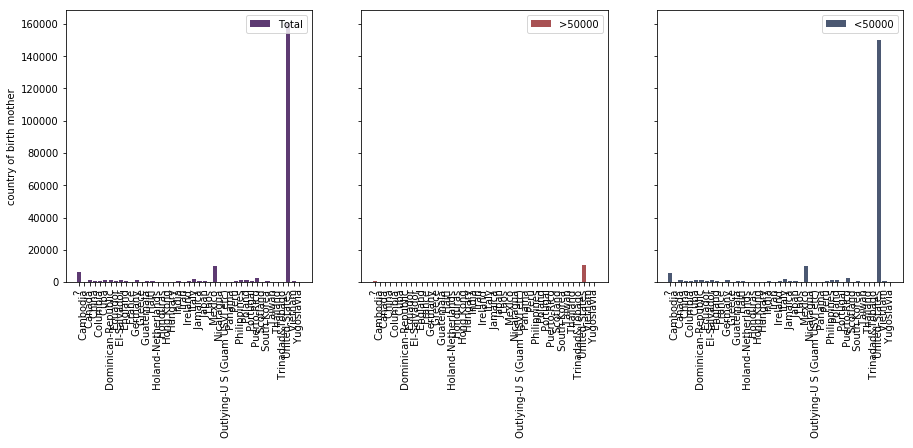

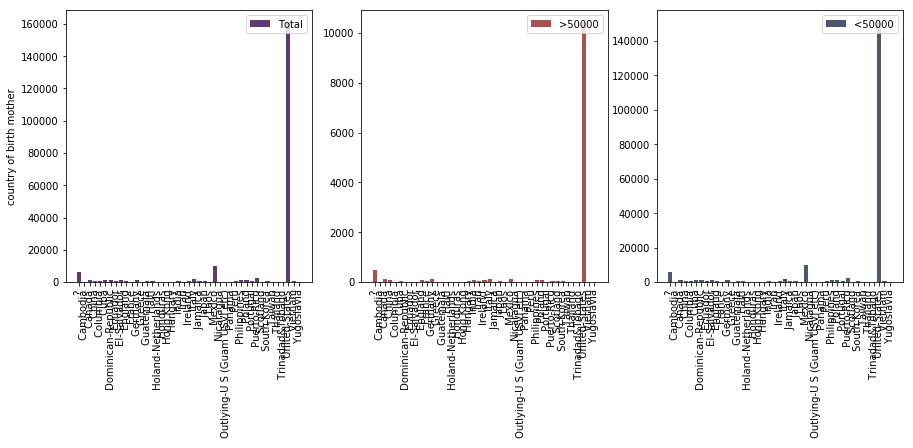

################################################################################
############################ country of birth self #############################
################################################################################


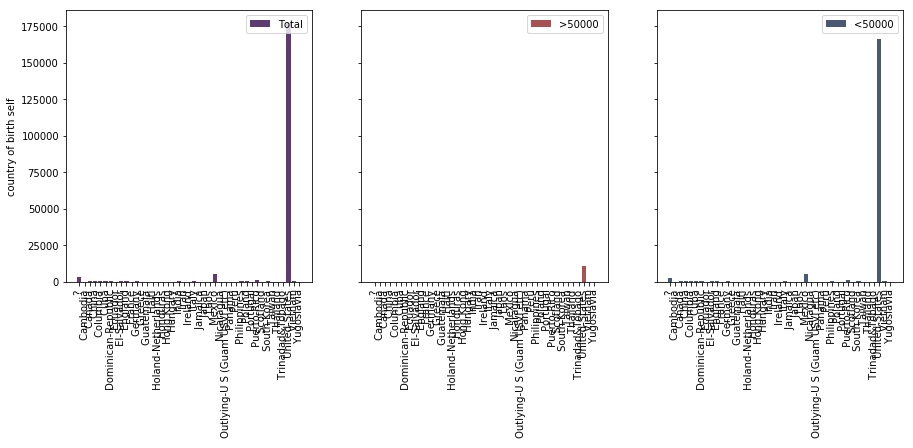

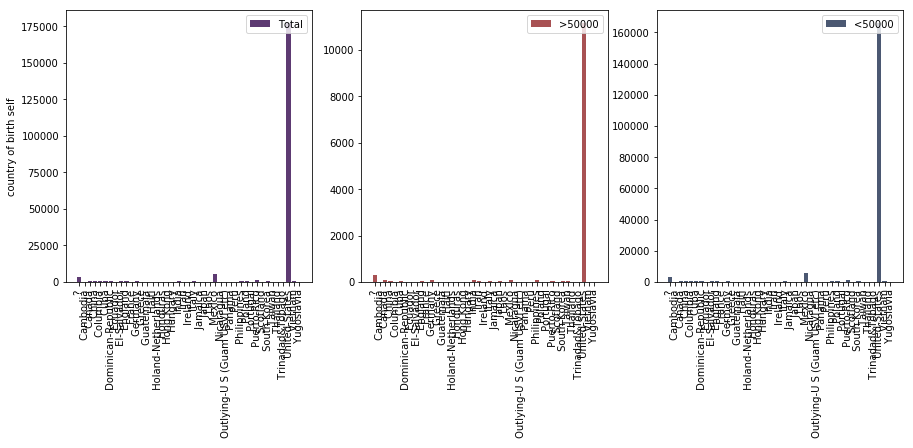

################################################################################
###################### detailed household and family stat ######################
################################################################################


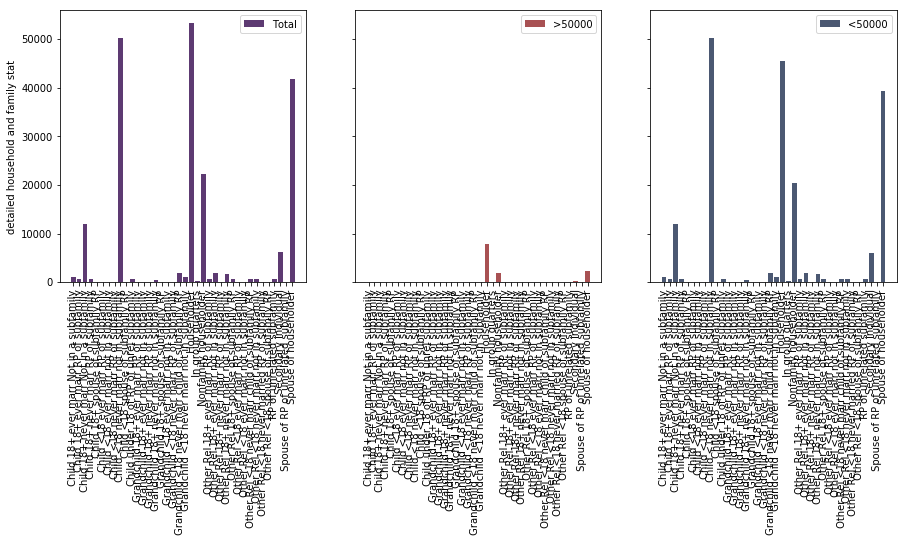

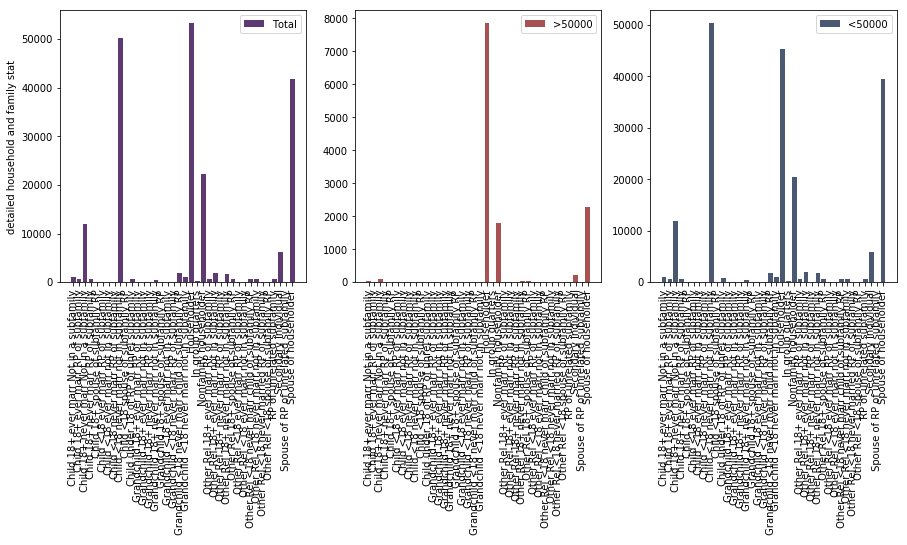

################################################################################
################### detailed household summary in household ####################
################################################################################


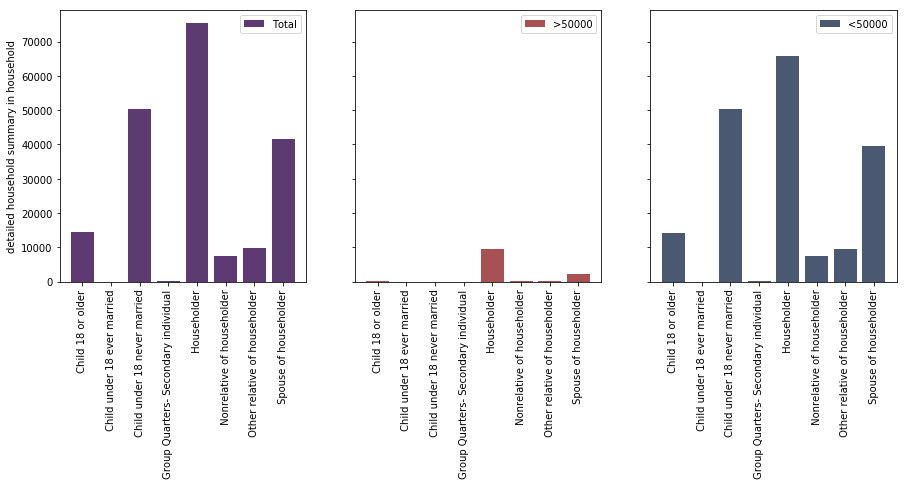

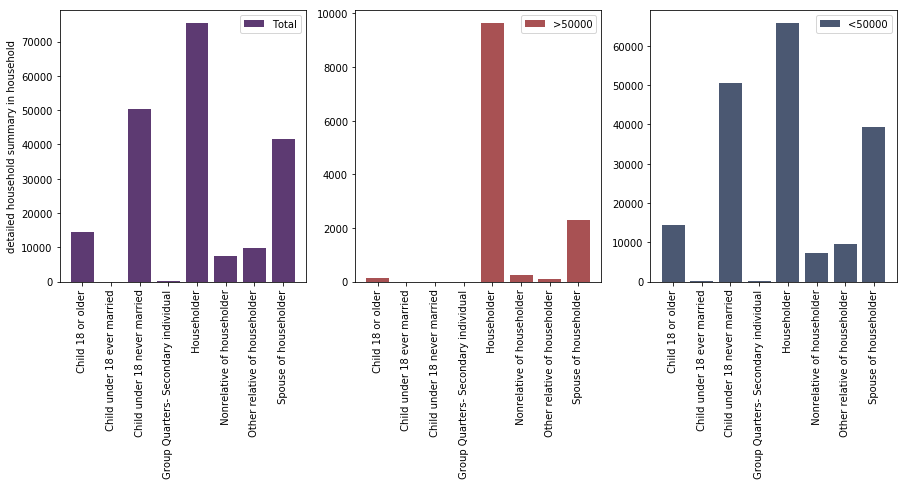

################################################################################
########################### detailed industry recode ###########################
################################################################################


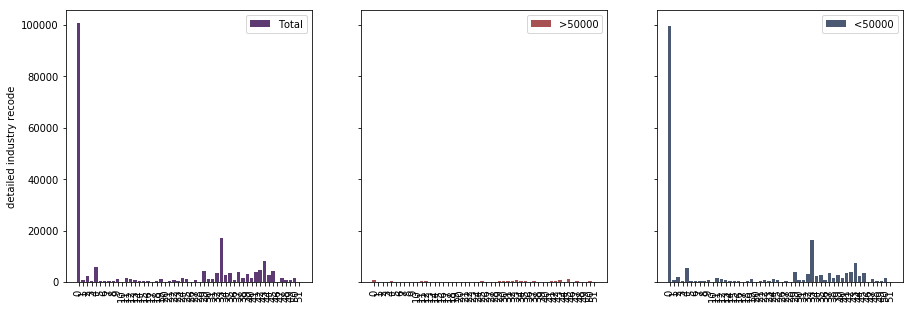

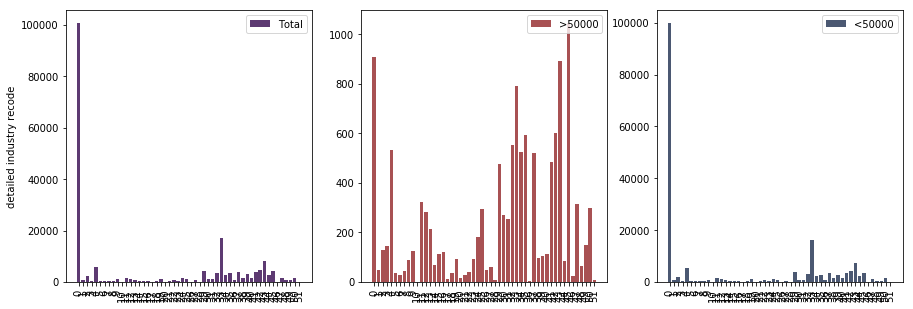

################################################################################
########################## detailed occupation recode ##########################
################################################################################


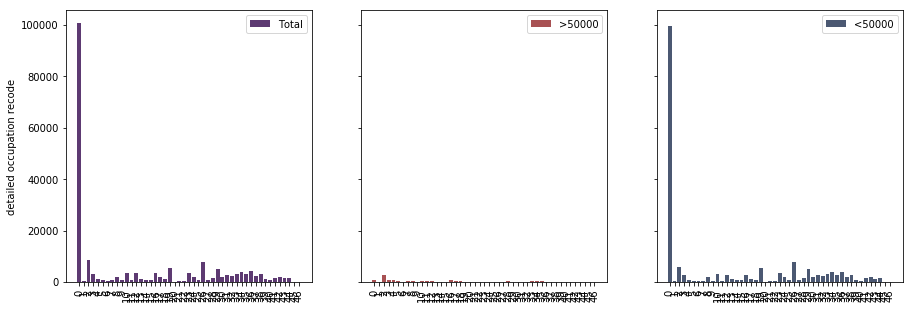

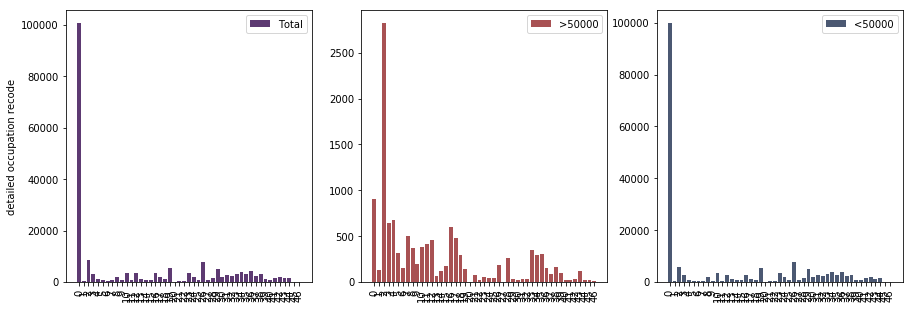

################################################################################
################################## education ###################################
################################################################################


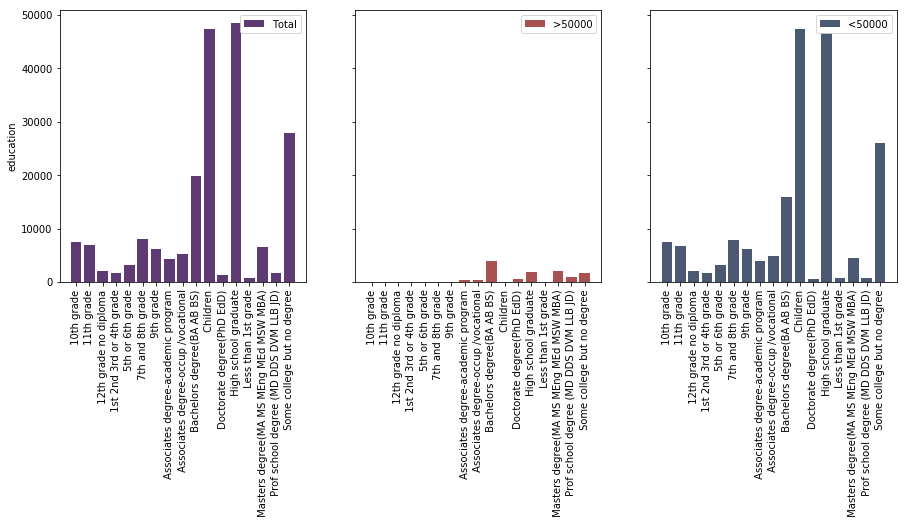

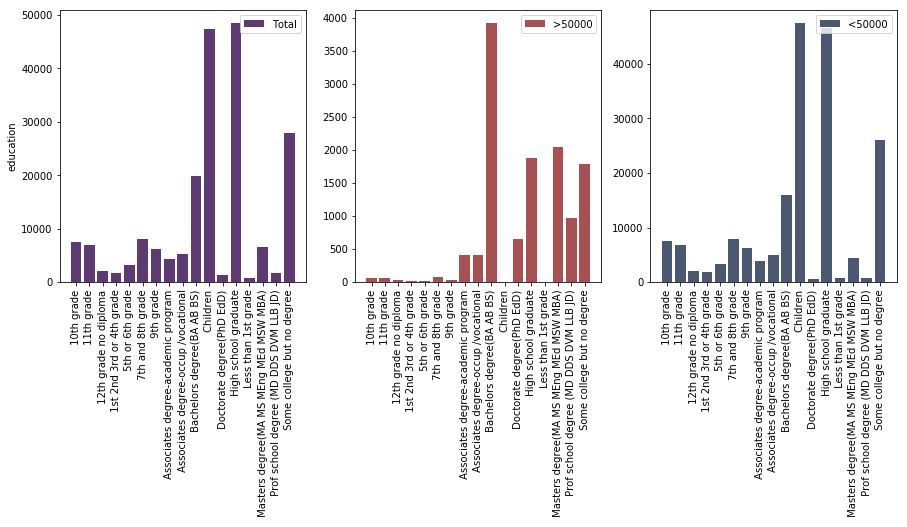

################################################################################
########################## enroll in edu inst last wk ##########################
################################################################################


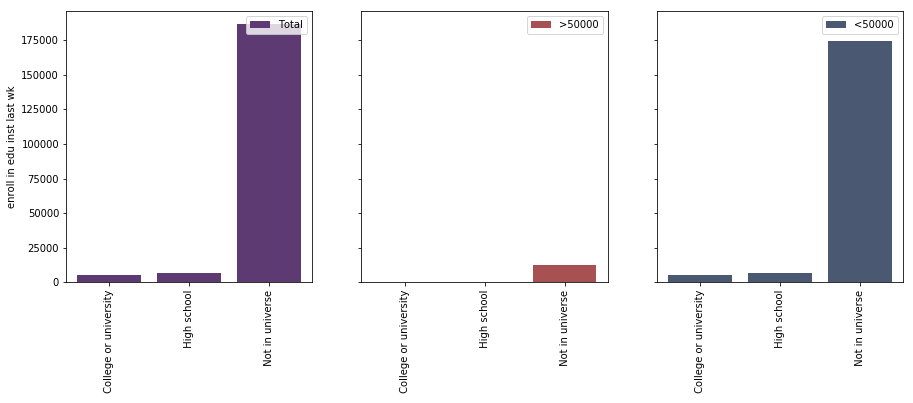

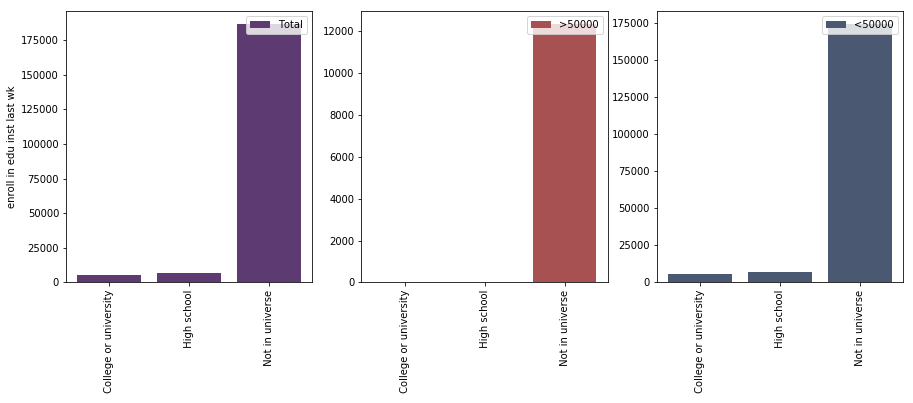

################################################################################
########################### family members under 18 ############################
################################################################################


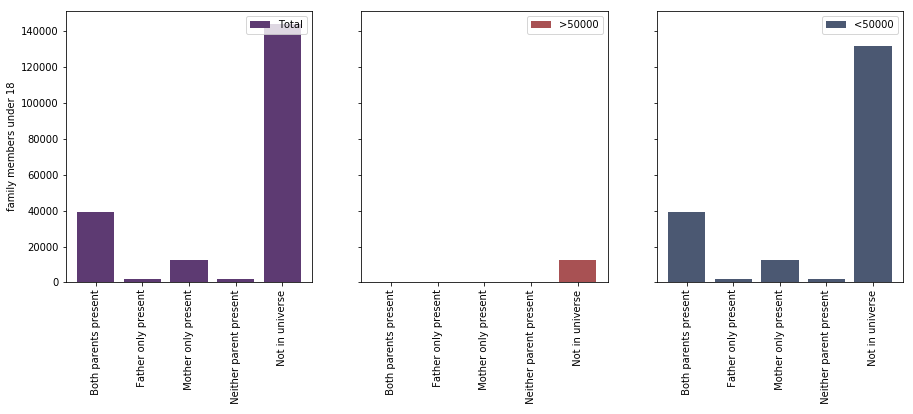

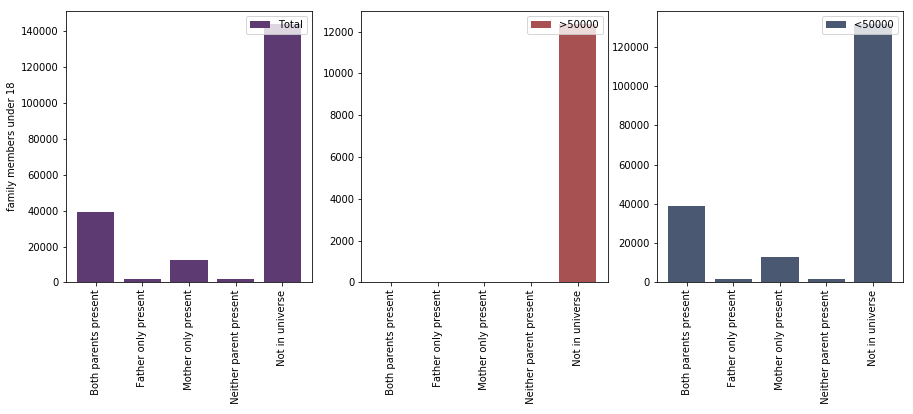

################################################################################
################## fill inc questionnaire for veteran's admin ##################
################################################################################


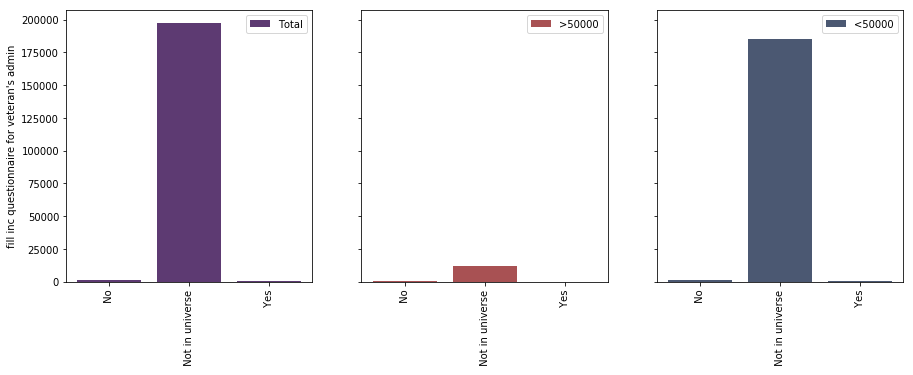

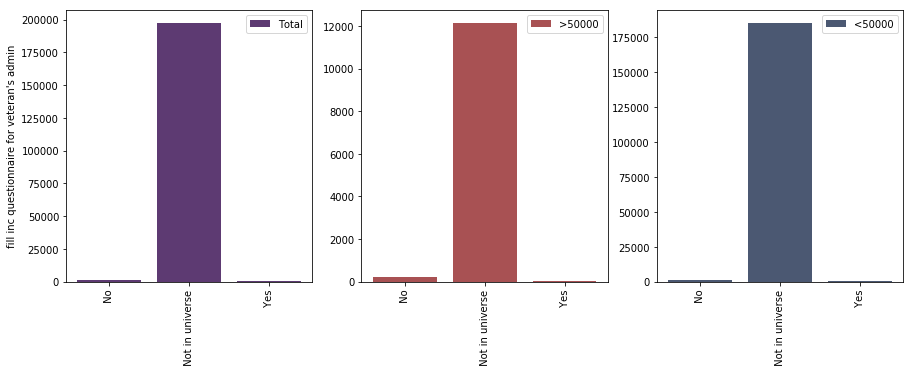

################################################################################
###################### full or part time employment stat #######################
################################################################################


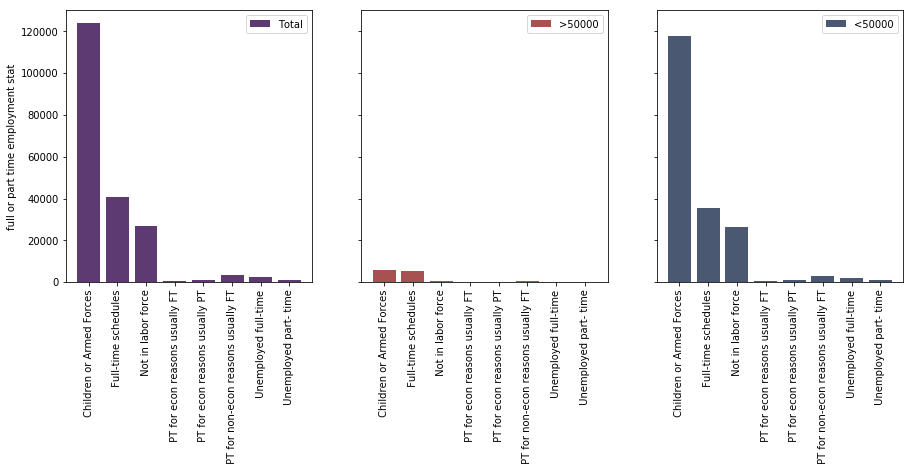

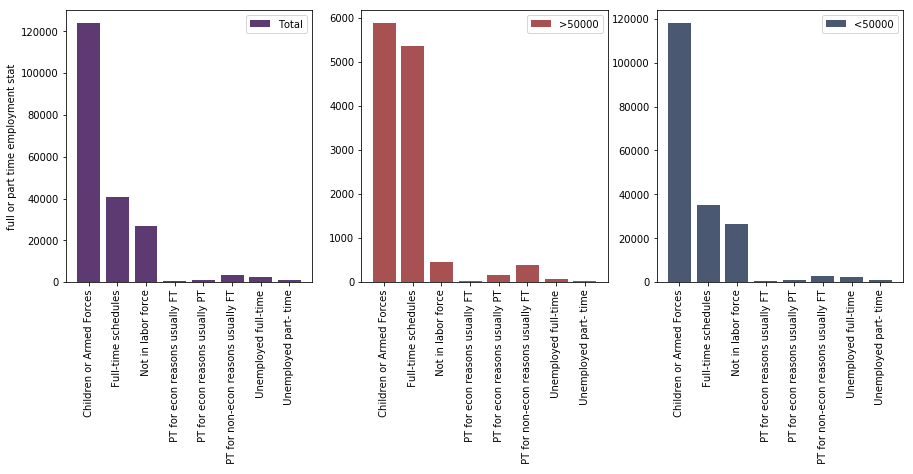

################################################################################
############################### hispanic origin ################################
################################################################################


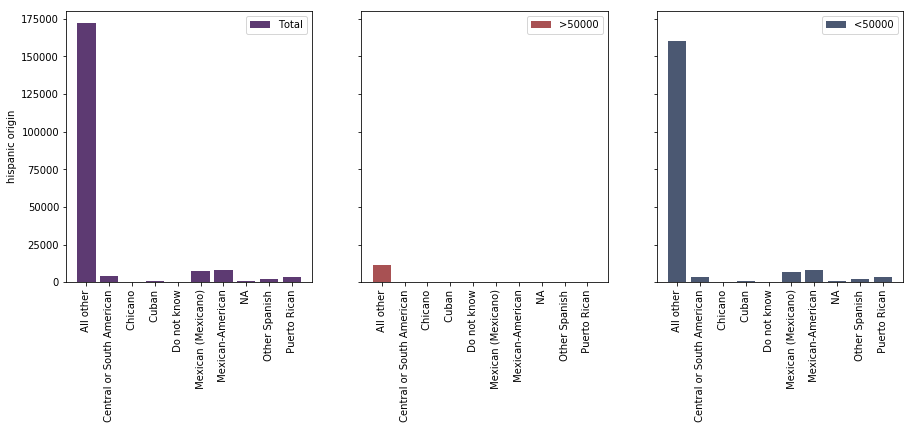

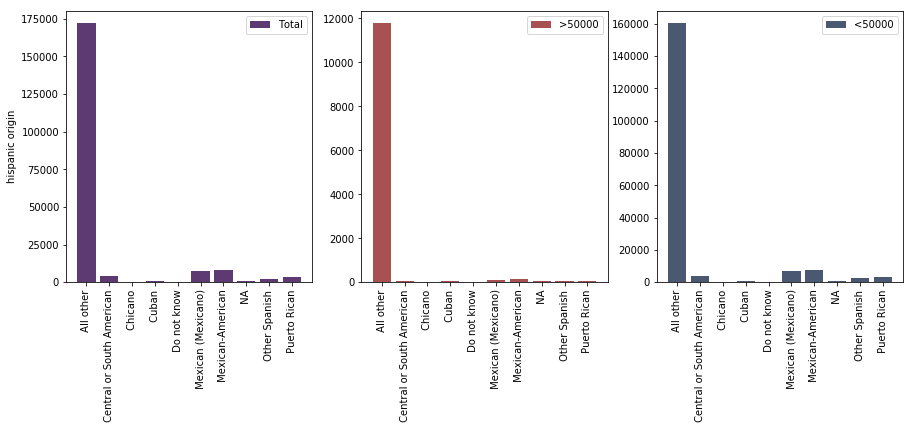

################################################################################
######################## live in this house 1 year ago #########################
################################################################################


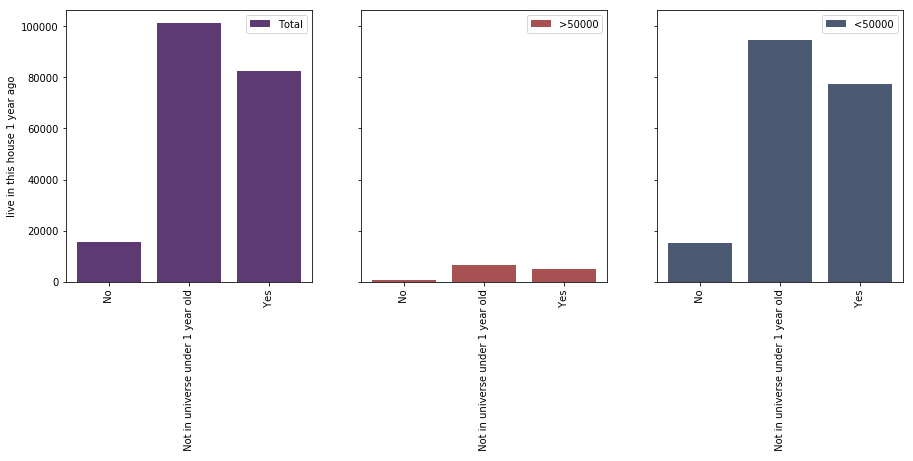

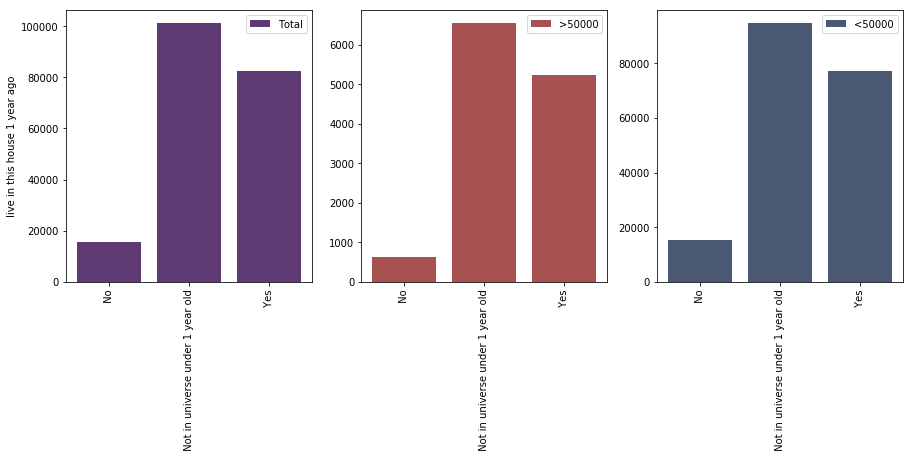

################################################################################
############################# major industry code ##############################
################################################################################


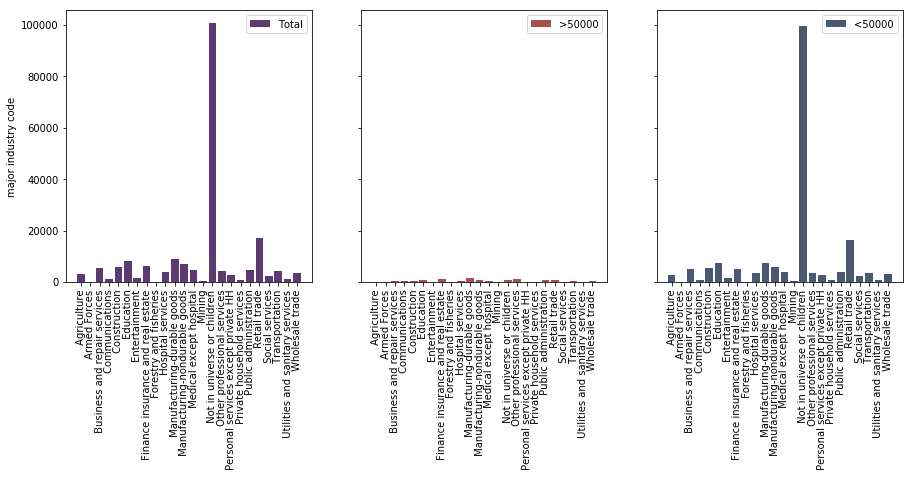

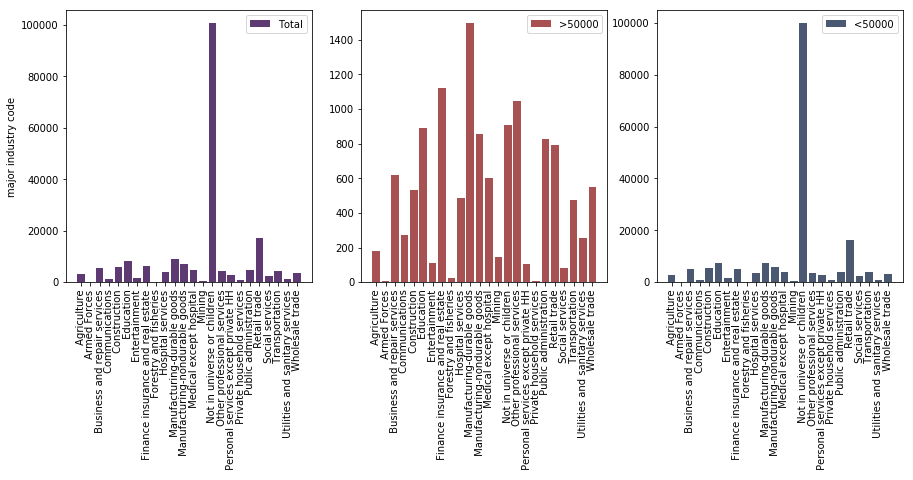

################################################################################
############################ major occupation code #############################
################################################################################


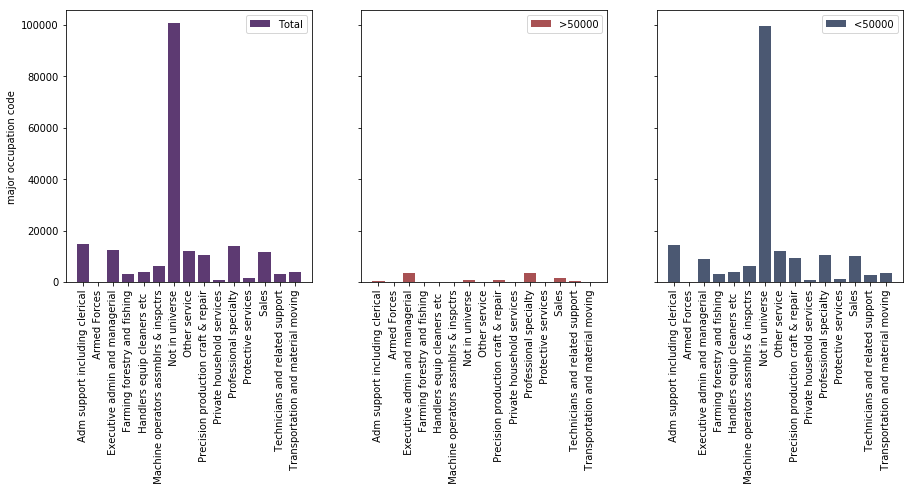

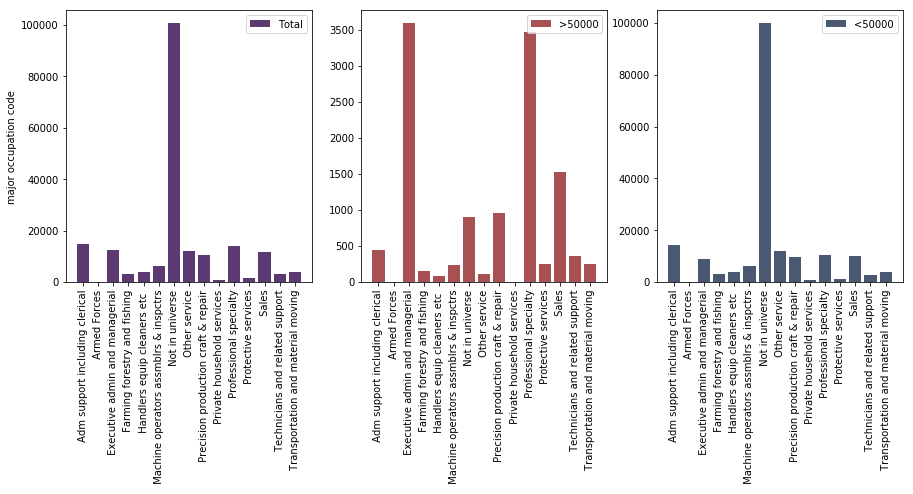

################################################################################
################################# marital stat #################################
################################################################################


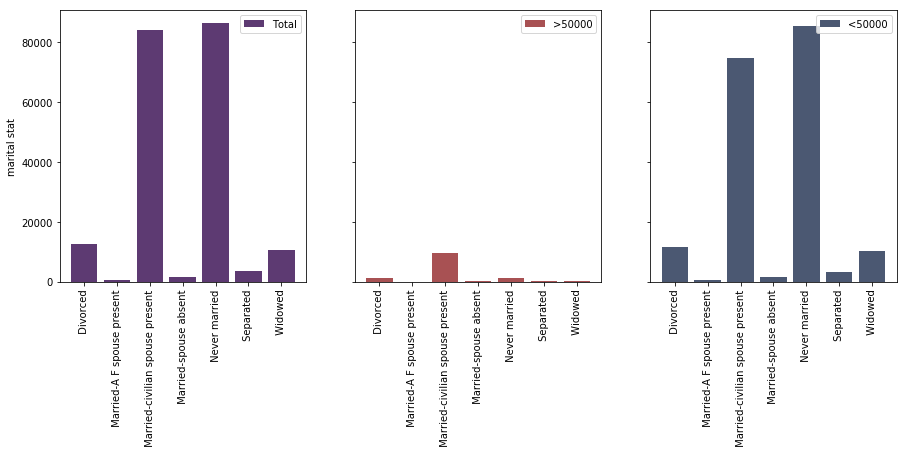

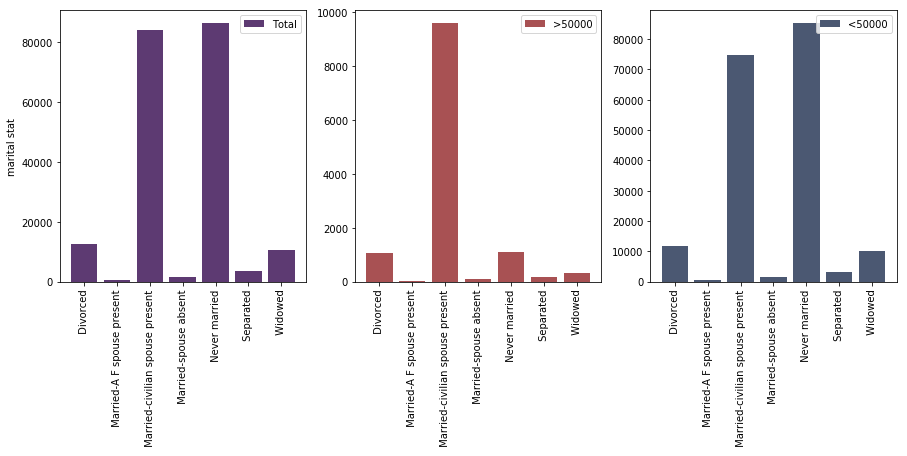

################################################################################
########################### member of a labor union ############################
################################################################################


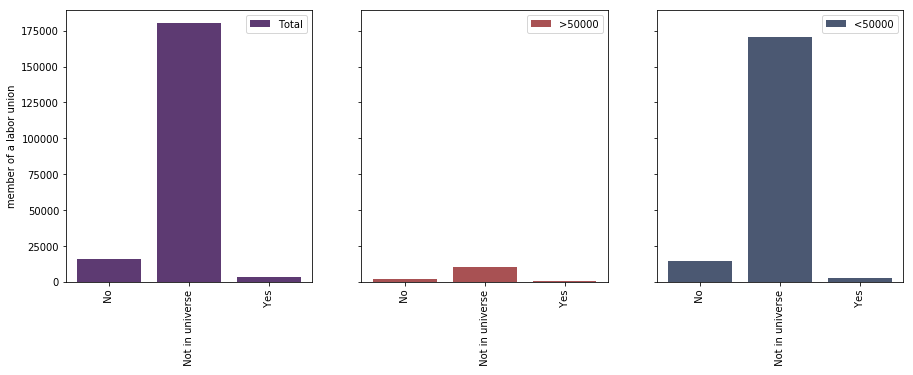

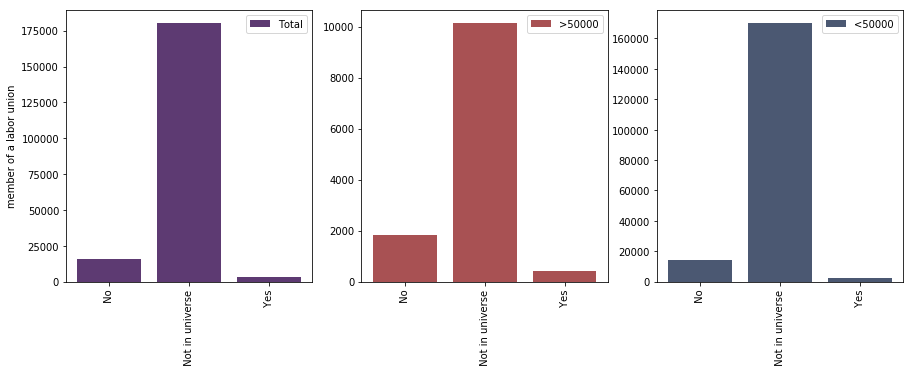

################################################################################
######################### migration code-change in msa #########################
################################################################################


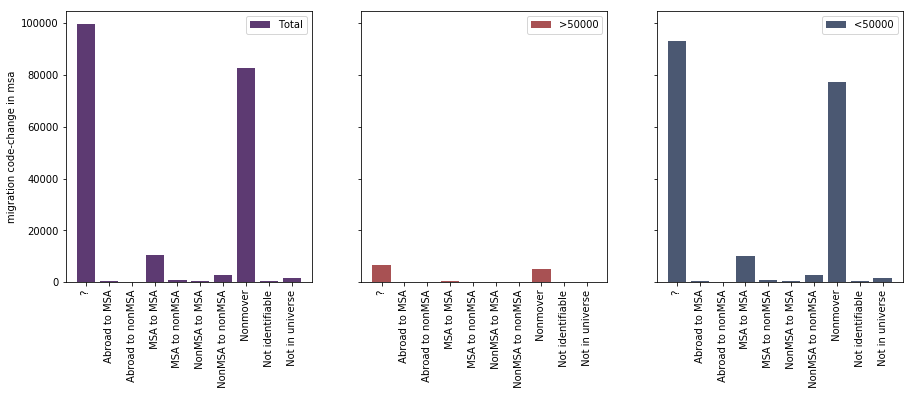

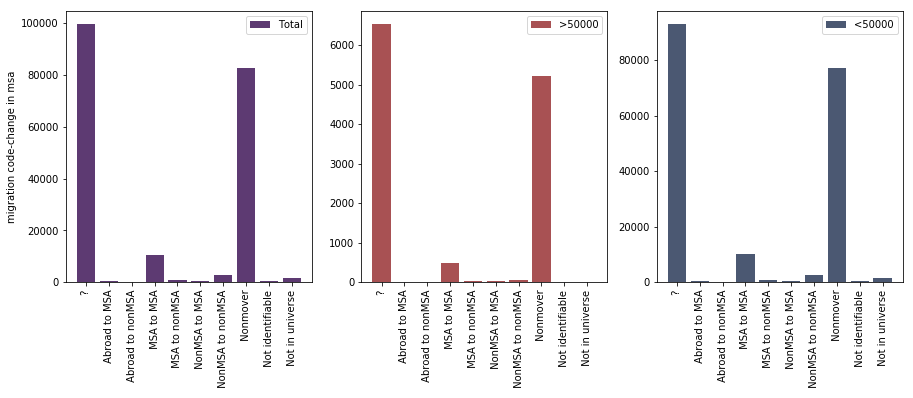

################################################################################
######################### migration code-change in reg #########################
################################################################################


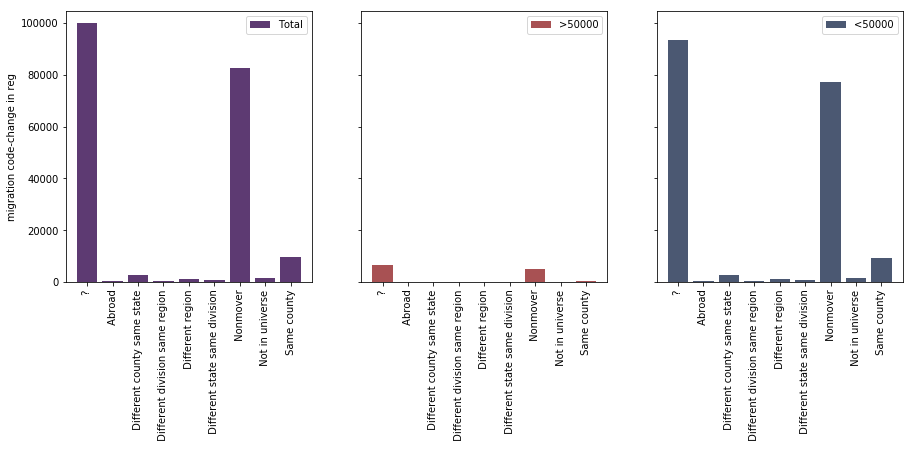

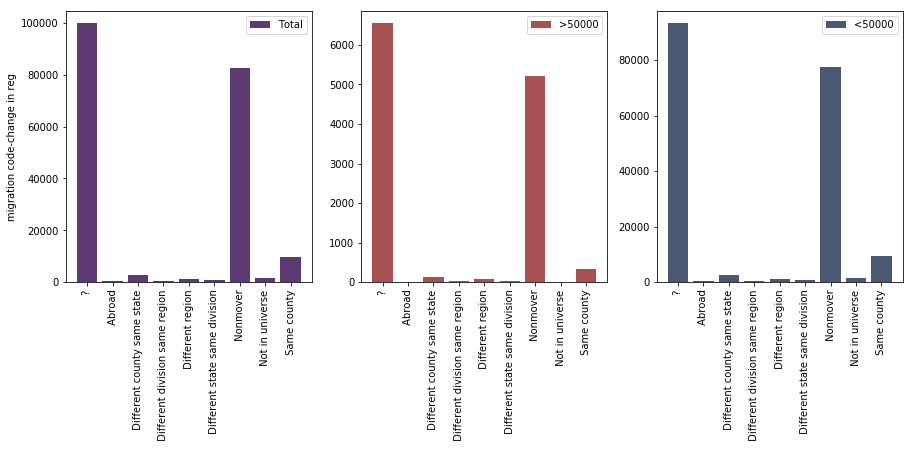

################################################################################
######################## migration code-move within reg ########################
################################################################################


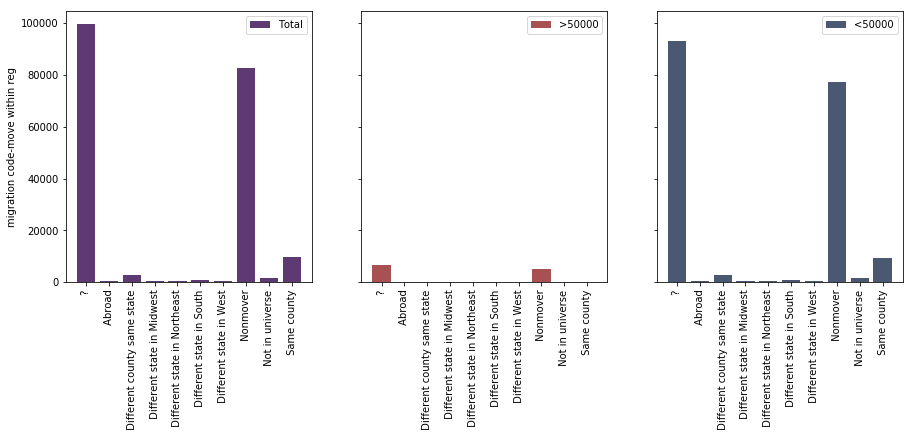

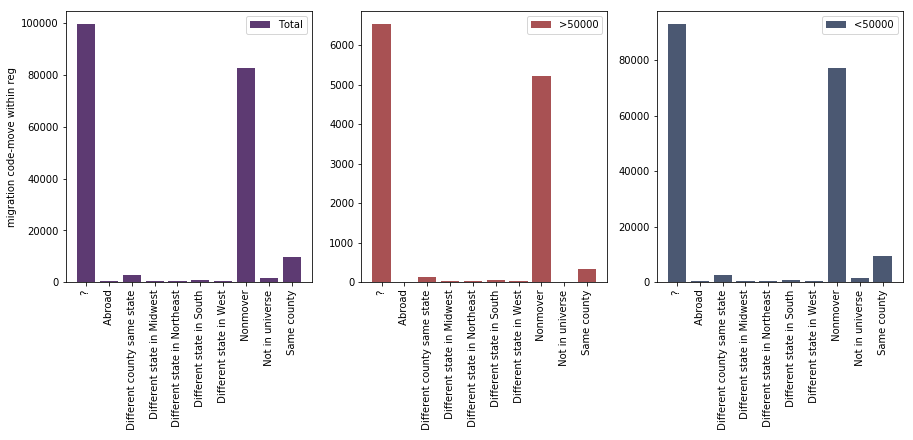

################################################################################
######################## migration prev res in sunbelt #########################
################################################################################


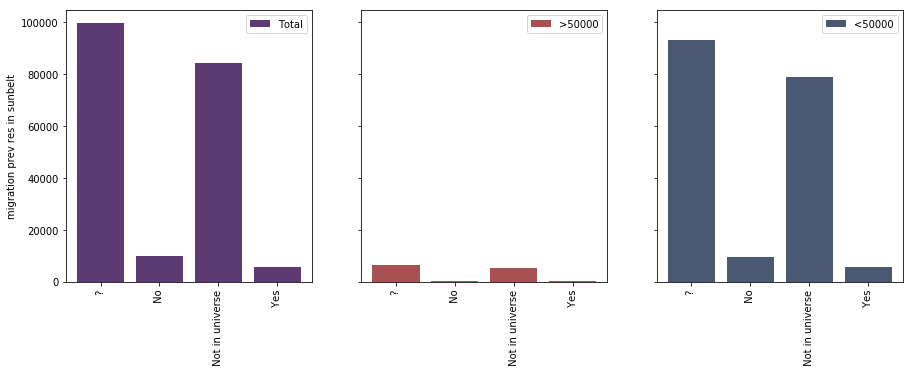

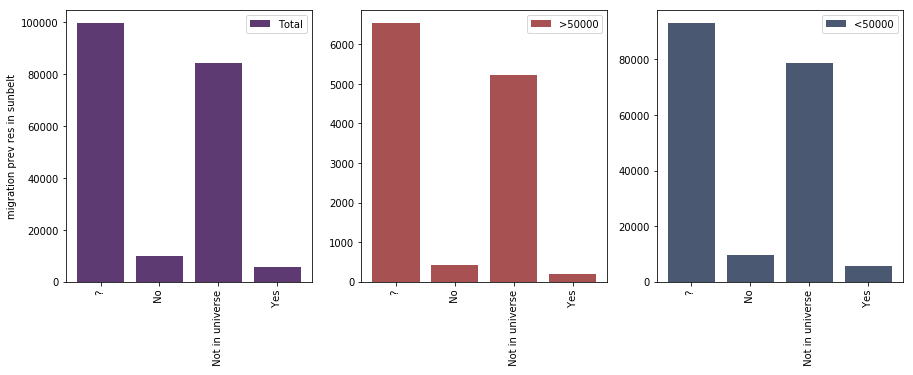

################################################################################
######################## own business or self employed #########################
################################################################################


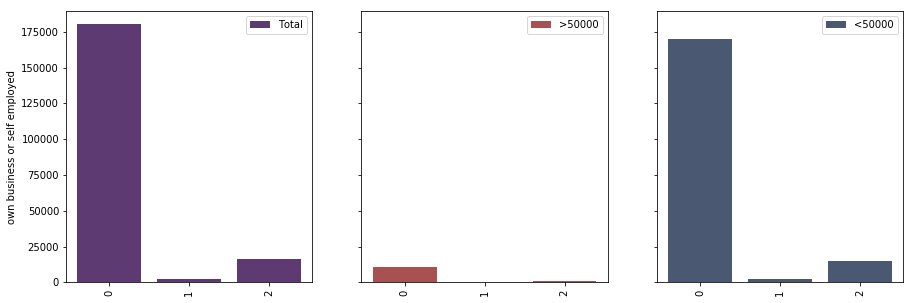

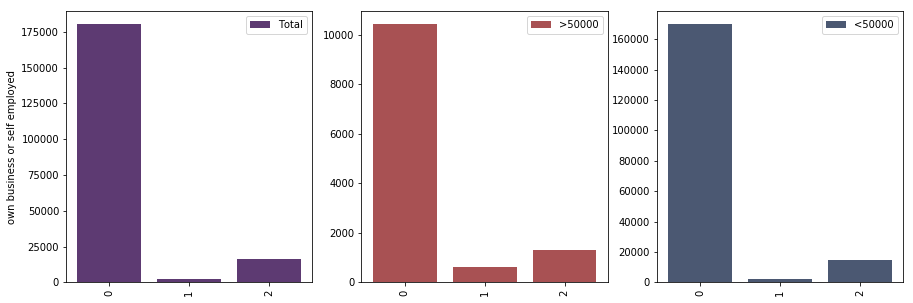

################################################################################
##################################### race #####################################
################################################################################


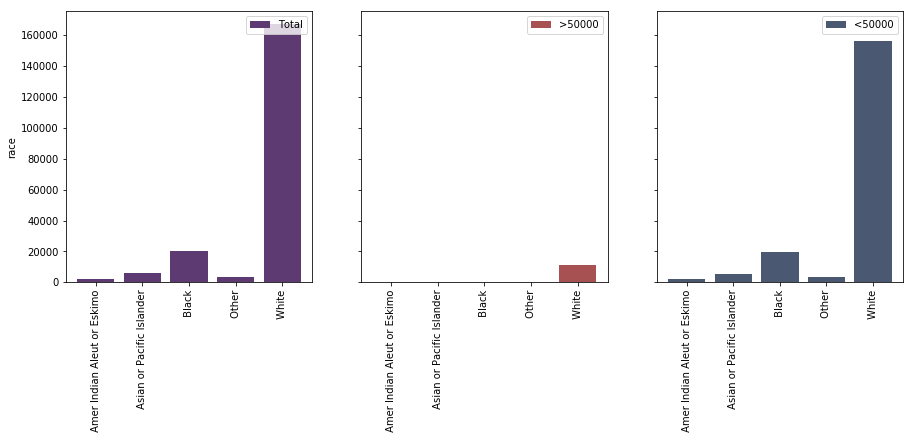

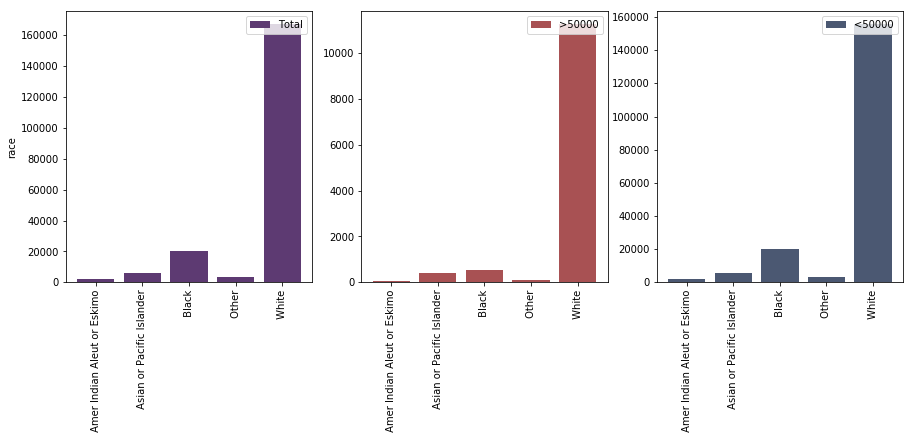

################################################################################
########################### reason for unemployment ############################
################################################################################


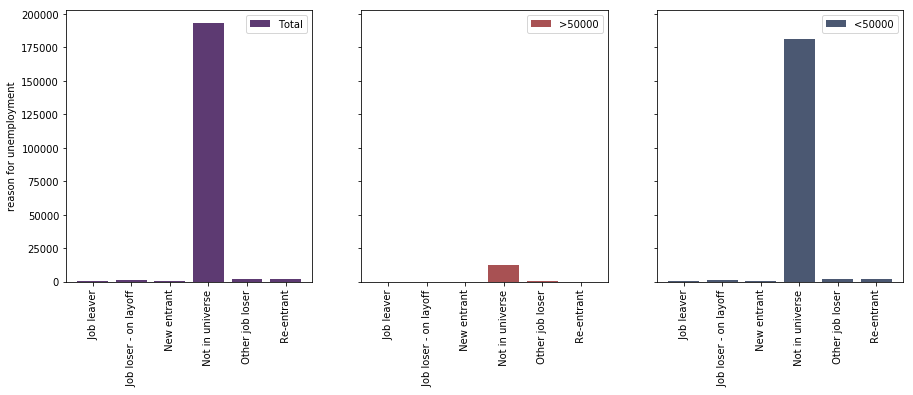

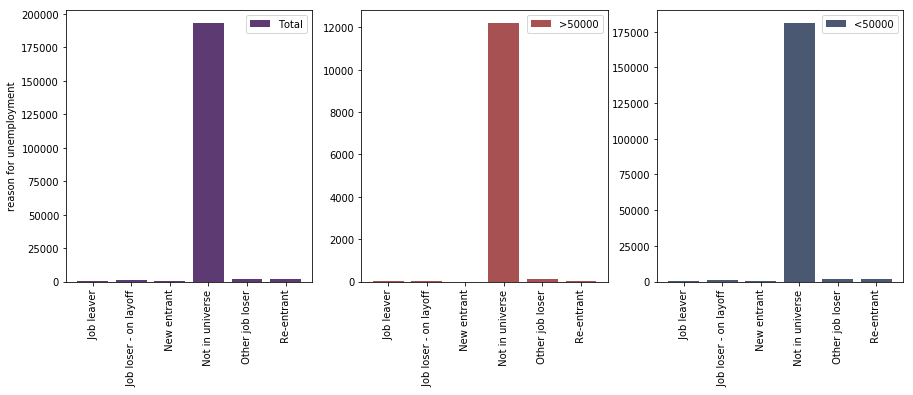

################################################################################
######################### region of previous residence #########################
################################################################################


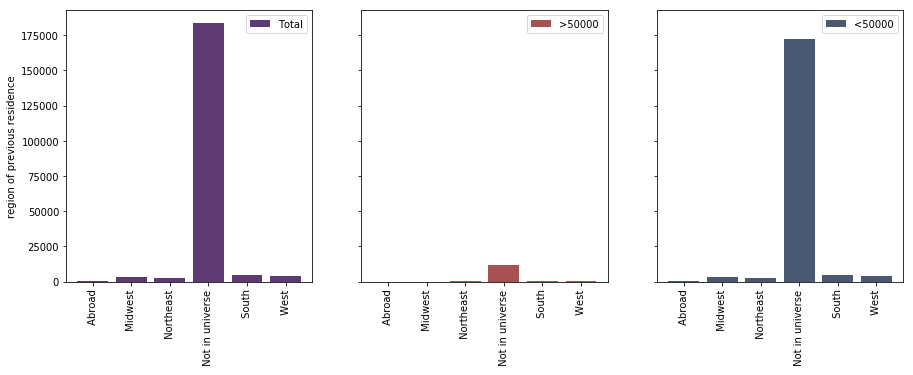

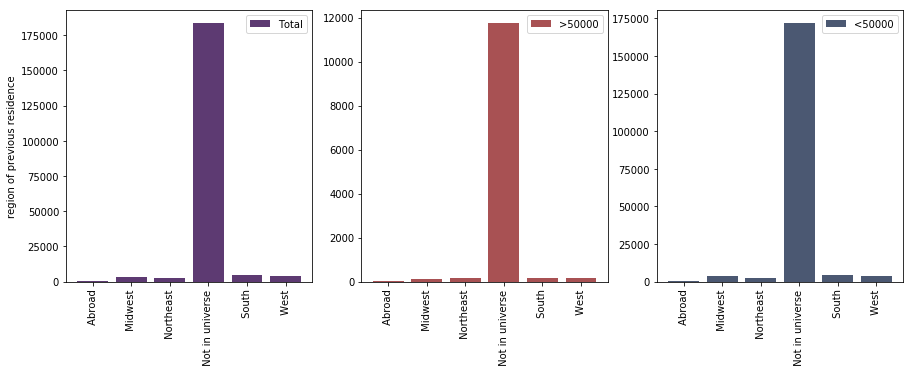

################################################################################
##################################### sex ######################################
################################################################################


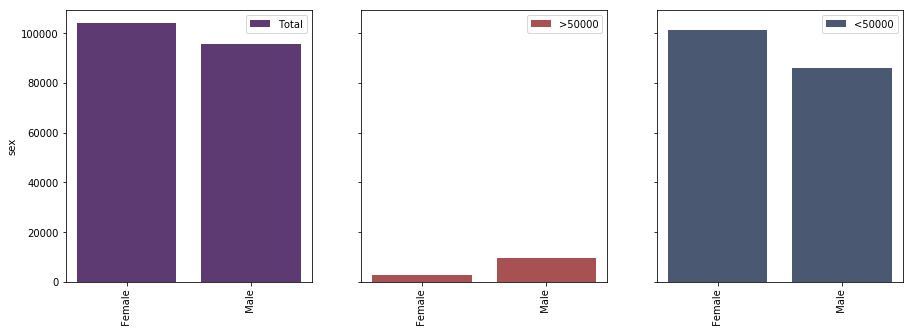

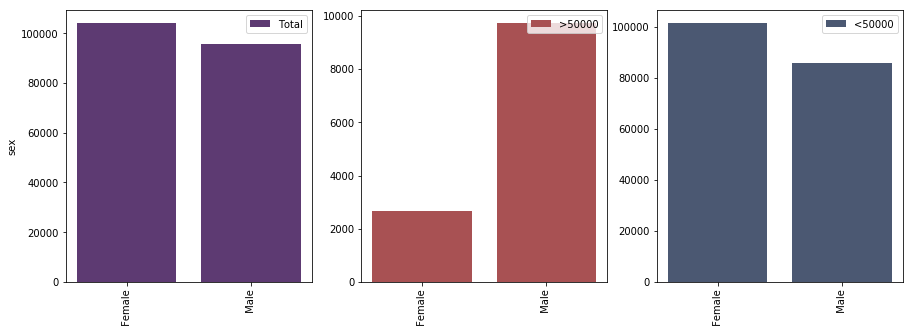

################################################################################
######################### state of previous residence ##########################
################################################################################


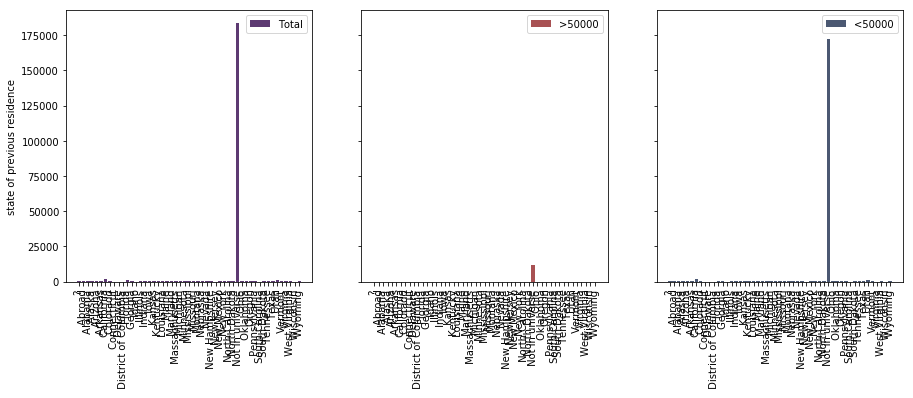

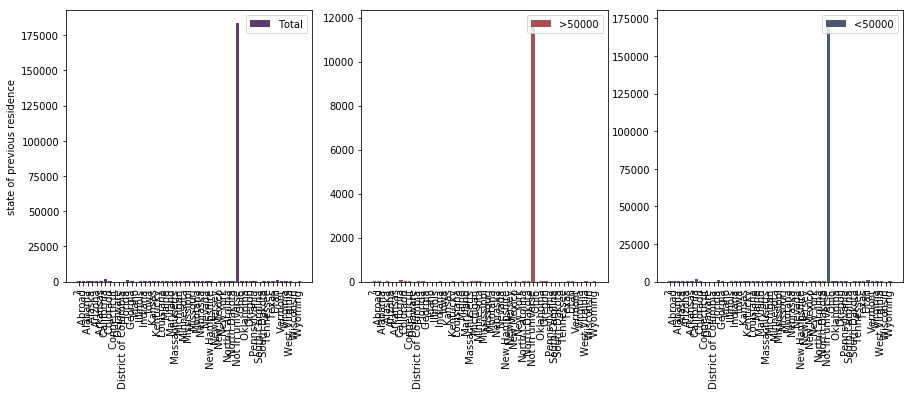

################################################################################
################################ tax filer stat ################################
################################################################################


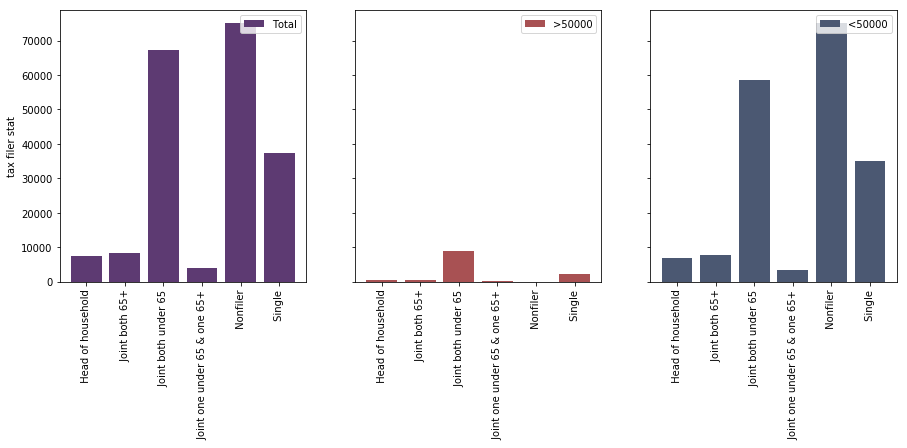

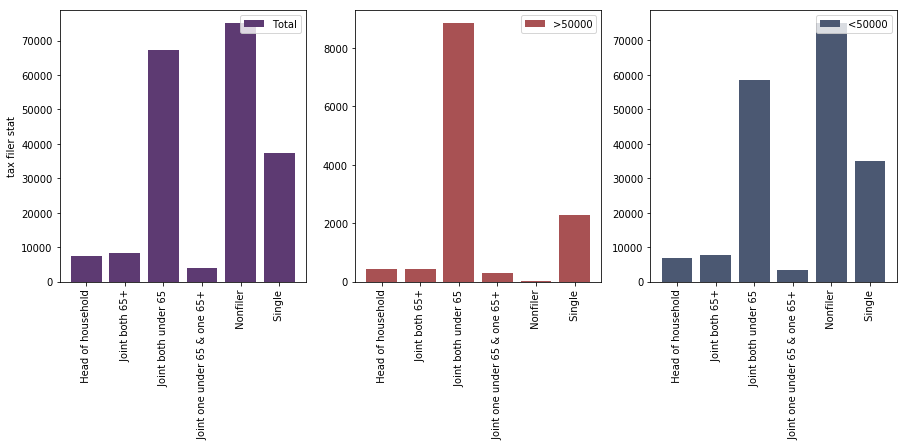

################################################################################
############################## veterans benefits ###############################
################################################################################


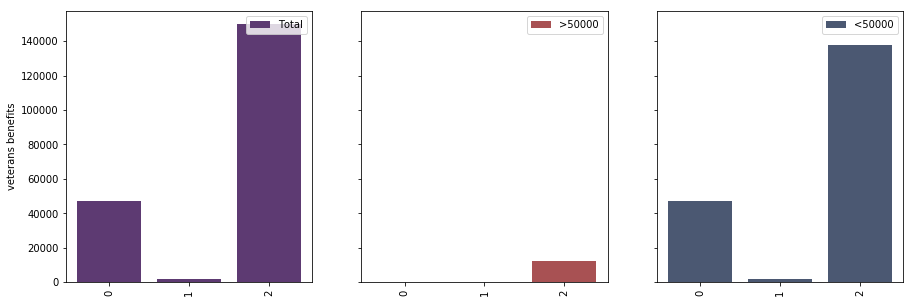

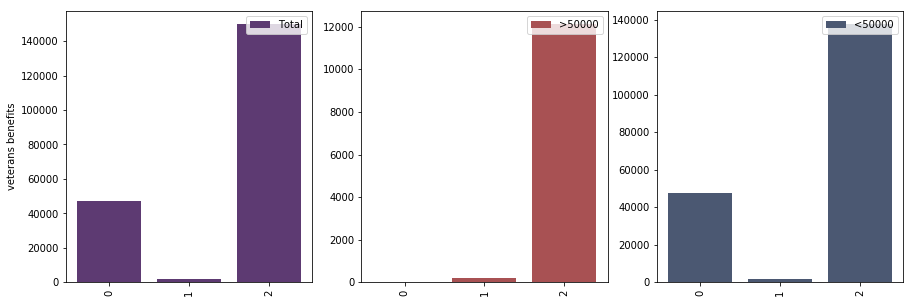

################################################################################
##################################### year #####################################
################################################################################


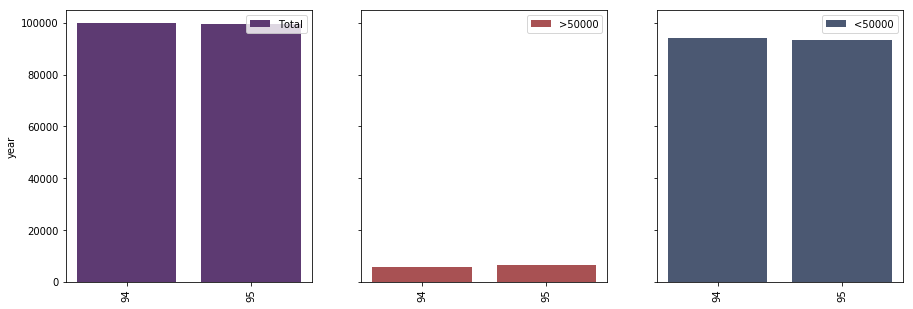

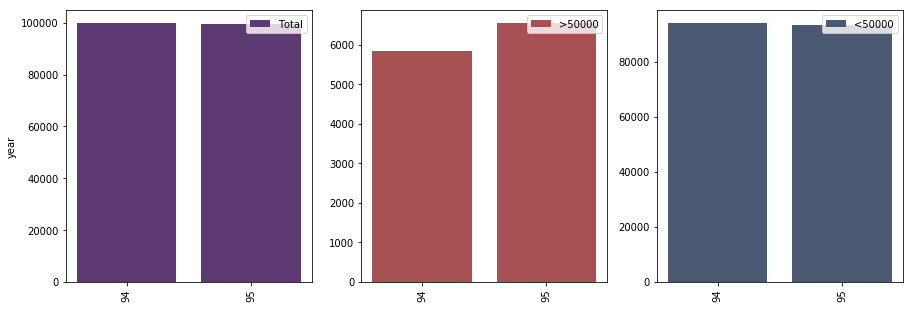

In [226]:
# Show bar chart distributions for all nominal data fields
# Warning: Takes a while to load
for col in sorted(nom_cols):
    print('#' * 80)
    print('{:#^80s}'.format(' ' + col + ' '))
    print('#' * 80)
    compare_bar_nom(col)
    compare_bar_nom(col, sharey=False)

In the interest of time, I can't go through each of these in as much detail as I did above for the continuous values. Depending on the timeline of the project and number of features in the datasey, I would do generally like to do this. However, below I note just a few interesting points:
* No data fields show any obvious quality issues
* **citizenship**: Foreigners who became US citizens are more prevalent at higher incomes - which makes sense from an talent acquisition standpoint.
* **class of worker**: Self-employed corporated workers are more prevalent at higher incomes
* **detailed household summary in household**: Those making above 50000 are much more likely to be the householder as opposed to those below 50000.
* **detailed industry/occupation recode**: much more variation in industry/occupation for those above 50000
* **education**: education level is skewed towards more advanced degrees for those making above 50000, which certainly makes sense.
* **enroll in edu inst last wk** - seems irrelevant
* **family members under 18** - due to preponderance of "Not in universe" - this field will likley be irrelevant.
* **full or part time employment stat** - relatively more full-time at high incomes
* **hispanic origin** - much more represented in the below 50000 group.
* **live in this house 1 year ago** - above 50000 are slightly more stationary
* **major occupation code** - more executives above 50000
* **marital stat** - above 50000 much more likely to be married
* **race** - minorities far less represented above 50000
* **sex** - very clear imbalance between the genders
* **tax filer stat** - those making more money almost certainly file their taxes
* **veterans benefits** - seem to have an effect, but it's unclear what the categories represent